## Library of Congress & Chronicling America

This notebook uses historic newspapers and select digitized newspaper pages provided by [Chronicling America](https://chroniclingamerica.loc.gov/about/) (ISSN 2475-2703).

This example is based on the [*Bourbon News*](https://chroniclingamerica.loc.gov/lccn/sn86069873/) began publication in 1881 in Millersburg, Kentucky under the ownership of Confederate veteran and former farmer Bruce Champ. By 1910, the paper had 3,000 subscribers, ranking it among the largest circulations in the Bluegrass region. The paper continued publishing until 1941.

[Chronicling America](https://chroniclingamerica.loc.gov/about/api/) provides an extensive application programming interface (API) which you can use to explore all of the data. The information is also [published as JSON](https://chroniclingamerica.loc.gov/lccn/sn86069873.json), including the OCR text files.

### Setting things up

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import pickle
import re
import os
from pathlib import Path
import requests
from collections import Counter
import matplotlib.pyplot as plt
from numpy import mean, ones
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Relationships between the volumes, issues and pages are describe in JSON. Each volume has several issues which contain several pages.

<img src="images/graph-loc.png">

### Let's retrieve the results!

The *Bourbon News* is accessible via a JSON file including all metadata. The attribute *issues* contains the URLs of all issues that, in turn, contain all *pages*.

In [2]:
url = 'https://chroniclingamerica.loc.gov/search/pages/results/?state=&date1=1848&date2=1848&proxtext=french+revolution&x=24&y=18&dateFilterType=yearRange&rows=20&searchType=basic&format=json'

https://opentexts.world/search?advanced=true&title=french+revolution&creator=&yearfrom=1848&yearto=1848&publisher=&placeofpublication=
    
https://www.europeana.eu/es/collections/topic/18-newspapers?page=1&qf=proxy_dcterms_issued%3A%5B1848-01-01%20TO%201848-12-31%5D&view=grid&api=fulltext
    
    https://newspapers.eanadev.org/api/v2/search.json?query=french%20revolution&profile=hits&wskey=J6W44jvPV&&qf=proxy_dcterms_issued:%5B1848-01-01+TO+1848-12-31%5D

SyntaxError: invalid syntax (<ipython-input-2-bd05797a2390>, line 3)

### Retrieving texts from in Chronicling America

In [3]:
count = 10
pagination = 100

queryString = 'french+revolution'
date = '1848'
page = 1

for page in range(9):
    url_pagination = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1='+ date +'&sort=relevance&rows=100&searchType=basic&sequence=0&state=&date2='+ date +'&proxtext='+queryString+'&y=18&x=24&dateFilterType=yearRange&page='+str(page+1)+'&format=json'
    print(url_pagination)
    r = requests.get(url_pagination)
    with open('ca-data'+str(page+1)+'.json', 'w') as outfile:
        json.dump(r.json(), outfile)


https://chroniclingamerica.loc.gov/search/pages/results/?date1=1848&sort=relevance&rows=100&searchType=basic&sequence=0&state=&date2=1848&proxtext=french+revolution&y=18&x=24&dateFilterType=yearRange&page=1&format=json


KeyboardInterrupt: 

In [4]:
import os, json
import pandas as pd

path_to_json = '.'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.startswith('ca-data') and pos_json.endswith('.json')]
print(json_files)  # for me this prints ['foo.json']

['ca-data4.json', 'ca-data6.json', 'ca-data8.json', 'ca-data5.json', 'ca-data9.json', 'ca-data3.json', 'ca-data2.json', 'ca-data1.json', 'ca-data7.json']


### Now you can use pandas DataFrame.from_dict to read in the json (a python dictionary at this point) to a pandas dataframe:

In [5]:
# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data = pd.DataFrame(columns=['edition', 'frequency', 'location', 'subject', 'date', 'publisher', 'language', 'identifier', 'provider', 'title', 'place_of_publication', 'text'])

In [6]:
   # JSON file 
#f = open('ca-data4.json') 
for js in json_files:
    print(js)
    f = open(js) 
  
    # Reading from file 
    data = json.load(f) 

    for i in data['items']:
        #print(i['sequence'])
        provider = 'Library of Congress'
        county = i['county']
        edition = i['edition']
        frequency = i['frequency']
        city = i['city']
        subject = i['subject']
        date = i['date']
        publisher = i['publisher']
        language = i['language']
        lccn = i['lccn']
        title = i['title']
        place_of_publication = i['place_of_publication']
        ocr_eng = i['ocr_eng']

        new_row = {'edition':edition, 'frequency':frequency,'location': city,'subject': subject,'date': date, 'publisher':publisher, 'language':language, 'identifier':lccn, 'provider': provider, 'title':title, 'place_of_publication':place_of_publication,'text': ocr_eng}

        jsons_data = jsons_data.append(new_row, ignore_index=True)


    f.close()

print(jsons_data.head(5))

ca-data4.json
ca-data6.json
ca-data8.json
ca-data5.json
ca-data9.json
ca-data3.json
ca-data2.json
ca-data1.json
ca-data7.json
  edition              frequency                              location  \
0    None  Daily (except Sunday)  [Alexandria, Alexandria, Alexandria]   
1    None    Daily (except Sun.)                         [New Orleans]   
2    None                 Weekly                             [Dubuque]   
3    None                  Daily                            [New York]   
4    None                  Daily                            [New York]   

                                             subject      date  \
0  [Alexandria (Va.)--Newspapers., Alexandria Cou...  18480411   
1  [Louisiana--New Orleans.--fast--(OCoLC)fst0120...  18480325   
2  [Dubuque (Iowa)--Newspapers., Dubuque County (...  18480126   
3  [New York (N.Y.)--Newspapers., New York (State...  18480504   
4  [New York (N.Y.)--Newspapers., New York (State...  18480512   

              publisher   langua

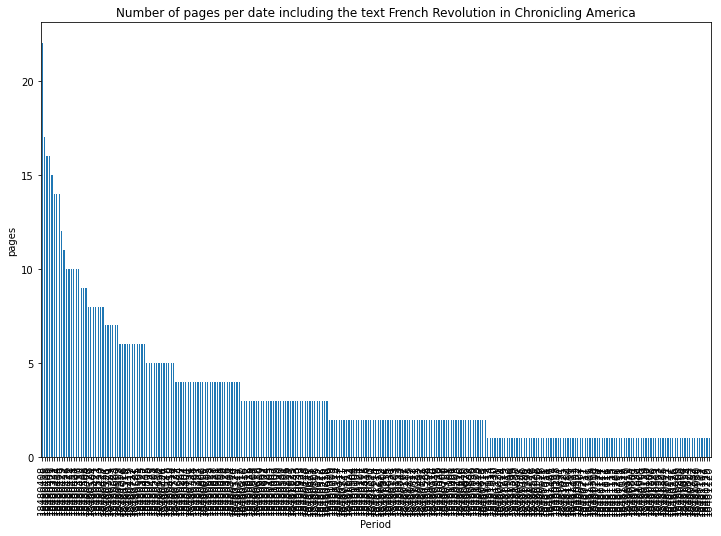

In [7]:
ax = jsons_data['date'].value_counts().plot(kind='bar',
                                    figsize=(12,8),
                                    title="Number of pages per date including the text French Revolution in Chronicling America")
ax.set_xlabel("Period")
ax.set_ylabel("pages")
plt.show()

In [8]:
jsons_data.groupby("date")["title"].count()

date
18480101    4
18480103    2
18480104    2
18480106    3
18480107    1
           ..
18481220    2
18481226    1
18481227    1
18481228    1
18481230    1
Name: title, Length: 275, dtype: int64

In [9]:
jsons_data.loc[jsons_data['date'] == '18480422']

,edition,frequency,location,subject,date,publisher,language,identifier,provider,title,place_of_publication,text
22,None,Weekly,[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Gales & Seaton,[English],sn83045784,Library of Congress,Weekly national intelligencer. [volume],Washington [D.C.],NATIONAL INTELLIGENCER.\nTEXAS AND THE UNITED ...
23,None,Weekly,[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Gales & Seaton,[English],sn83045784,Library of Congress,Weekly national intelligencer. [volume],Washington [D.C.],"j?c. n\nkiriT.lc'r-'.'L^, ?...! th.1 ?fa, lh....."
44,None,Daily (except Sunday and Monday),[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Thomas Ritchie & John P. Heiss,[English],sn82003410,Library of Congress,The daily union. [volume],Washington [D.C.],"m""?"" """""" IITC mt | -A. A/ .2^ llf J*. - -A--....."
78,None,Weekly,[Louisville],"[Antislavery movements--Kentucky--Newspapers.,...",18480422,P. Seymour,[English],sn82015050,Library of Congress,The examiner. [volume],"Louisville, Ky.",THE EXAMINER.\nJ. ' VAIHiHsN. r.niM.\nr. CWBr....
219,None,Semiweekly (Three times a week during sessions...,[Indianapolis],[Indiana--Indianapolis.--fast--(OCoLC)fst01205...,18480422,G.A. & J.P. Chapman,[English],sn82014301,Library of Congress,Indiana State sentinel. [volume],Indianapolis [Ind.],3nMana State 0mtuuL\n7CRMAL TIGILASCr. II THE ...
439,None,Daily (except Sunday),"[Alexandria, Alexandria, Alexandria]","[Alexandria (Va.)--Newspapers., Alexandria Cou...",18480422,Edgar Snowden,[English],sn85025007,Library of Congress,Alexandria gazette. [volume],"Alexandria, D.C.",j\nP l' B 1.1 S H K I) 1) A I I. \ AS l> I K I...
440,None,Daily (except Sunday),"[Alexandria, Alexandria, Alexandria]","[Alexandria (Va.)--Newspapers., Alexandria Cou...",18480422,Edgar Snowden,[English],sn85025007,Library of Congress,Alexandria gazette. [volume],"Alexandria, D.C.","ALEXANDRIA\nS.VlTRPAY MORNING, APRIL >i, lv*v\..."
639,None,Weekly,[Woodsfield],"[Ohio--Woodsfield.--fast--(OCoLC)fst01234336, ...",18480422,J.R. Morris,[English],sn85038115,Library of Congress,The spirit of democracy. [volume],"Woodsfield, Ohio","THE SPIRIT OF DEMOCRACY.\n. JAB. R. MORRIS, PR..."
769,None,Weekly,[Baton Rouge],"[Baton Rouge (La.)--Newspapers., French Americ...",18480422,Morison & Devalcourt,"[English, French]",sn82003383,Library of Congress,Baton-Rouge gazette. [volume],"Baton-Rouge, La.",m*\nmv n\nIA 7i K\ntu\nJOll* IWHlW»\n• HHITOlt...
863,None,Daily (except Sun.),[New Orleans],[Louisiana--New Orleans.--fast--(OCoLC)fst0120...,18480422,Hayes & M'Clure,[English],sn82015378,Library of Congress,The daily crescent. [volume],"[New Orleans, La.]",DAILY CRESCENT.\nSPRING FLOWERS.\nby the autho...


In [10]:
jsons_data.date.unique()

array(['18480411', '18480325', '18480126', '18480504', '18480512',
       '18480516', '18480622', '18480522', '18480525', '18480417',
       '18480426', '18480404', '18480509', '18481209', '18480115',
       '18480304', '18480401', '18480408', '18480415', '18480422',
       '18480429', '18480506', '18480520', '18480527', '18480722',
       '18480916', '18481007', '18481014', '18481028', '18480708',
       '18480826', '18480302', '18480323', '18480409', '18480425',
       '18480428', '18480502', '18480526', '18480604', '18480609',
       '18480610', '18480613', '18480702', '18480714', '18480729',
       '18480925', '18481020', '18480911', '18481012', '18480407',
       '18480728', '18480330', '18480518', '18480308', '18480503',
       '18480510', '18480607', '18480823', '18480621', '18480816',
       '18480405', '18480128', '18480623', '18481214', '18480805',
       '18481125', '18480725', '18480414', '18480616', '18480412',
       '18480501', '18480624', '18480921', '18480603', '184811

In [11]:
jsons_data.language.astype(str).unique()

array(["['English']", "['English', 'Hawaiian']", "['English', 'French']"],
      dtype=object)

In [12]:
jsons_data.count()

edition                  16
frequency               900
location                900
subject                 900
date                    900
publisher               877
language                900
identifier              900
provider                900
title                   900
place_of_publication    900
text                    900
dtype: int64

### Retreiving texts from Europeana newspapers

In [ ]:
https://newspapers.eanadev.org/api/v2/search.json?query=french%20revolution&profile=hits&wskey=J6W44jvPV&&qf=proxy_dcterms_issued:%5B1848-01-01+TO+1848-12-31%5D&rows=10&start=500

In [15]:
count = 100

queryString = 'french%20revolution'
start = 1
eu_apikey = 'J6W44jvPV'
fileCount = 0

for page in range(10):
    url_pagination = 'https://newspapers.eanadev.org/api/v2/search.json?query='+queryString+'&profile=hits&wskey='+eu_apikey+'&&qf=proxy_dcterms_issued:%5B1848-01-01+TO+1848-12-31%5D&rows='+str(count)+'&start='+str(start)
    start = start + count
    print(url_pagination)
    r = requests.get(url_pagination)
    
    fileCount = fileCount +1
    with open('eu-data'+str(fileCount)+'.json', 'w') as outfile:
        json.dump(r.json(), outfile)

https://newspapers.eanadev.org/api/v2/search.json?query=french%20revolution&profile=hits&wskey=J6W44jvPV&&qf=proxy_dcterms_issued:%5B1848-01-01+TO+1848-12-31%5D&rows=100&start=1


KeyboardInterrupt: 

In [16]:
path_to_json = '.'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.startswith('eu-data') and pos_json.endswith('.json')]
print(json_files)  # for me this prints ['foo.json']

['eu-data5.json', 'eu-data4.json', 'eu-data10.json', 'eu-data6.json', 'eu-data8.json', 'eu-data3.json', 'eu-data9.json', 'eu-data7.json', 'eu-data2.json', 'eu-data1.json']


con el di monto maniafest
/9200359/BibliographicResource_3000115929718

del manifest recojo sequencues/canvases/othercontent 

del other content cojo el page y recojo el texto


https://iiif.europeana.eu/presentation/9200356/BibliographicResource_3000118390149/manifest?wskey=J6W44jvPV

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929718/manifest?wskey=J6W44jvPV


https://www.europeana.eu/api/fulltext/9200396/BibliographicResource_3000118435063/8ebb67ccf9f8a1dcc2ea119c60954111

https://pro.europeana.eu/page/iiif

In [17]:
for js in json_files:
    print(js)
    json_file = open(js) 
  
    # Reading from file 
    data = json.load(json_file) 

    for i in data['items']:
        
        # id
        id = i['id']
        
        manifestUrl = 'https://iiif.europeana.eu/presentation/' + id + '/manifest'
        responseManifest = requests.get(manifestUrl, params = {'wskey': eu_apikey })
        print(responseManifest.url)
    
        # retrieving the metadata
        m = json.loads(responseManifest.text)
    
        # retrieving metadata
        title = m['label'][0]['@value']
        thumbnail = m['thumbnail']['@id']
        date = m['navDate']
        license = m['license']
        
        ## Full text is accessible in otherContent property
        for s in m['sequences']:
            for c in s['canvases']:
                print(c['otherContent'][0])
                responseFullText = requests.get(c['otherContent'][0], params = {'wskey': eu_apikey })
                
                # retrieving the metadata
                eu_fulltext = json.loads(responseFullText.text)
         
                full_text = ''
                if 'resources' in eu_fulltext:
                    for f in eu_fulltext['resources']:
                        if(f['dcType'] == 'Page'):
                            print(f['resource']['@id'])
                            responseFullTextPage = requests.get(f['resource']['@id'], params = {'wskey': eu_apikey })

                            eu_fullTextPage = json.loads(responseFullTextPage.text)
                            #print(eu_fullTextPage)

                            file_name = f['resource']['@id'].replace('https://www.europeana.eu/api/fulltext/','').replace('/','-')

                            # saving the full texts json files
                            with open('eu-fulltext/' + file_name +'.json', 'w') as outfile:
                                json.dump(responseFullTextPage.json(), outfile)

                            full_text = full_text + "\n" + eu_fullTextPage['value']
                  
                with open('eu-fulltext/total_' + id.replace('/','_') + '.json', 'w') as outfile:
                    outfile.write(full_text)                        
        
        if 'edmPlace' in i:
            location = i['edmPlace']
        if 'edmConcept' in i:
            subject = i['edmConcept']
        publisher = i['provider']
        language = i['language']
        identifier = i['id']
        provider = i['dataProvider']
        title = i['title']

        new_row = {'edition':'', 'frequency':'','location': location,'subject': subject,'date': date, 'publisher':publisher, 'language':language, 'identifier':identifier, 'title':title, 'provider': provider, 'place_of_publication':'','text': full_text}
        
        jsons_data = jsons_data.append(new_row, ignore_index=True)

    json_file.close()

eu-data5.json
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051782374/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782374/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782374/2368af4b1d8713ae1cf98593effbb094
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782374/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782374/43b3003c32c78bd0da51c0787c4376ec
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782374/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782374/fb2a6a947600d2f7e09f5ba92ed35377
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782374/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782374/999d07008ae1d8394315c1e8c13ed742
https://iiif.europeana.eu/presentation/92

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014834/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014834/22893c9c0a83e313c7a0e056dffbd472
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014834/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014834/1d3de21dc673d3b68b4fcf5103c0c7ce
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014834/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014834/71d7f3f87174fb7800d0fe99829fe31a
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014834/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014834/3b2b83301ab3b8c791fdb3a784cb848a
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014834/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014828/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014828/471f3be20d0a7f36aa090fedb784ce16
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014828/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014828/d50110388b5daaa93c108285e66bad08
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014828/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014828/d44c73651ceb67b46208afa4e6ad47d3
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014828/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014828/656b8943015b847f9cd69981b94023fc
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014828/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014775/f221925fa3b8632b8dd046c04a5a2446
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014775/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014775/5054c00aa197b3a8160f2104b6b3d4e8
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014775/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014775/5e760f0bc310bfc95d527d2c8250fe6c
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014775/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014775/339fb5ba0e2f9bc347cfa47c4c47262d
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014775/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014775/c33080bba27d4892c57e3741975b3ec0
https://iiif.europeana.eu/presentation/9200333/Bi

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852286/fe29329d78882f9574650fa98997c9e3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852286/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852286/5a56f55490bd052dcd5844e7c0079b16
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051837315/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051837315/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051837315/f3a8516e256d02befec5879b01ff2bd0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051837315/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051837315/fa0273e431a5ca82c250e661d55463cf
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051837315/annopage/3
https://www.europeana.eu/api/fulltext/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051843430/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051843430/5dad775a5ff931cba10e40c218ef9a2e
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650357/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650357/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650357/417a577b44d9accbac8300e374910248
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650357/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650357/2a6e228e49f0bbfeb621025fe2cd308e
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650357/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650357/9f564223a23bd2d8fad261f3e1d6b853
https://iiif.europeana.eu/presentation/9200338/Bibliog

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824683/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824683/70a700e56a7d35adf81b23f713a48dec
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824683/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824683/422307f2571df3c62b6e042c5d6a5345
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824683/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824683/607247c1c1f0e873385e910867b7a0d0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824683/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824683/985b0d93b98f77a1dda06717fc1839d2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824683/annopage/19
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014722/cef55582ffb09813b7a56ed0f1512728
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014722/annopage/14
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014722/5293646f212a87f8d056eb73582dbdb6
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014722/annopage/15
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014722/cbda690b6924cdb96461fa0f5cbfe5a0
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014722/annopage/16
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014722/fc2b38638a9ef61bd16fe8dfb3157c08
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014722/annopage/17
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014722/86519b6413411ffaf971fba6defd4b48
https://iiif.europeana.eu/presentation/920033

https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051788620/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051788620/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788620/8a2850579bde899f3846b4766a14106b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051788620/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788620/b3d966acfe3501e8b07c0235ff0d1fea
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051788620/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788620/06cd99a84ae42fd15574d8b09fb67001
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051788620/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788620/a96ce9f8fe14e7586ce94315a330b10b
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650432/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650432/0e51d19c536a97c5d5660da3398159c9
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650432/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650432/072994ce1f1e977ad997e858596b492d
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650432/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650432/d878ac517e99f9bfb4361bccc7074033
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650432/annopage/6
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650432/7c0bd9173f087ff84861431f01dd4e20
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650432/annopage/7
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978938/8a10414a0fe27c2df146b1cefa724a0c
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000058978938/annopage/2
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978938/7d694bd1be1ab11649757c60d4f5b06b
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000058978938/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978938/9328d09e622c442b0b672e6c68a678dc
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000058978938/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978938/4c5edb026a4bc829deabfa6304a0f5be
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000058978938/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978938/f84eb67fd4bd4c247776fa17661e233e
https://iiif.europeana.eu/presentation/9200333/Bi

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840918/92eba97b67ba9b5177182c50bae1653e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840918/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840918/b93eed3dcb0b6ec327d5e67a976a5b8a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840918/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840918/b5c6be92f9f78fa4c4872329e839a0d8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840918/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840918/5dc7d48f703533e4b0619ba12e65dc1a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840918/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840918/8947ed28e3ef63822900bf2fd26d1e8b
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978969/92b99f7ddbfcc8beb495132f205b3589
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000058978969/annopage/2
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978969/12c1a2e4c4f818cd0ac72b99fe220336
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000058978969/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978969/4fda38a7f6c0e1e8ec8686bdc3e4894b
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000058978969/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978969/2c75a6a966fa7a938b1a1cf2533d7b6f
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000058978969/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000058978969/3c48989869abb12f0dd93c23678b0682
https://iiif.europeana.eu/presentation/9200333/Bi

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051861579/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051861579/bdd68fa5e29328cda7c5af5401904ce1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051861579/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051861579/b36fd867b06964142be21f3f43a13b2e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051861579/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051861579/db9b7931458336a86447b550a165cc67
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051821275/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821275/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821275/ade6ab22bd58981c00f0876be9634ee2
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051783613/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051783613/dff98cc20e69ae1569049969a94ff880
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051783613/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051783613/bc597ec236205dfb1079e9e86f214b2f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051783613/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051783613/7465064bd087a8add1f985cbdf41ccc6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051783613/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051783613/0de340abce8dc323001243ec4a86b84b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051783613/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784507/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051784507/8220376d5189427219f245ebd1ecf1c1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784507/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051784507/9571b26f5070adb633210bc46ac19bb5
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784507/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051784507/1b7f4776730b7f13df5ae105d487c51d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784507/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051784507/30d54c55511d96344891eebb035747c3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784507/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839412/56617fe368609e26b2fd6167d8b9320e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839412/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839412/82217a6171a1a3d910835dc26856ccf6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839412/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839412/74bf409f483998b54155239b17748fad
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051852819/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852819/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852819/317b70a0e888ed00e18b84eb4c5c417b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852819/annopage/2
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841628/9e83c66879171fd30fb6146b21bb7a3c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051841628/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841628/7bb82541267aa6a334e4fce18ee3605a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051841628/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841628/637c58ae27725cf537bee6a50da00bbb
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051841628/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841628/ad76e969ebd51741d907086e4099c357
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051841628/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841628/133e3957a5082235dd808a8694d3923c
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation//9200333/BibliographicResource_3000059014734/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014734/annopage/1
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014734/77bc1871f78cf840c08350679d059b5b
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014734/annopage/2
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014734/ad1e1f7469bcd5d000464cde15d81931
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014734/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014734/bf079690fb361bd81b18290736aad4c4
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014734/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014734/5ec08e9deecdd4ba687dfcac379b441c
https://iiif.europeana.eu/presentation//9200300/Bibliog

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858654/e290ee540d55c1ba46df2cc25110b4f8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858654/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858654/c4447a74efd9c46f3a471fc632ad14d1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858654/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858654/e6e4a545107c041b89a2cfd9d33ce548
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858654/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858654/677d24e0ba16e5490be53207dd4e2ea5
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858654/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858654/2ac1b0d3ed8d7516f097c1e2262afc63
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850071/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850071/49fde9ecace7df431327dfc17a3838e6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850071/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850071/648ba6b87bcb6067ac7d16b8366ba8ea
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850071/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850071/ba5eceea06c031f52fdae0d1fe91185c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850071/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850071/d9ab8000aa55c66265d2ad42b60dcf62
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850071/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853206/annopage/27
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853206/ec38976c83b542716b7770e1e0813102
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853206/annopage/28
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853206/annopage/29
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853206/5af39b2f9bd01423bb463e63086f408d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853206/annopage/30
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853206/983c0cec35b698182df6078b26bd98d2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853206/annopage/31
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853206/79653265dae480fda3e4a24f4056caf7
https://iiif.europeana.eu/presentation/9200300/BibliographicResou

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051845178/ea7a0d9b86a5815c9f560b91df54cc70
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051845178/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051845178/1ea9bf307c7c21fa082e1e1d838dcd41
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051845178/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051845178/055f6f9fd7e684a6769a3f2cd86f1181
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051845178/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051845178/7ef079b57119f97ce7b5bf2f236788e3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051845178/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051845178/329694f2108bcb904c366b38fd3bfe58
https://iiif.europeana.eu/presentation/9200300/B

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830212/478221f27f21c43d4b47a84a6b2efc99
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830212/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830212/e06f6fa2c9a3dcb443c851567474b0ff
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830212/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830212/574809d0d0d900bed7467493ae4dedf1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830212/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830212/52e12cc64a252dc9e1e6ebd71ca6a85c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830212/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830212/7f50c9b3e83246c64e995cbab095da7a
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826558/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826558/0fb396db3bf4d526b243bf2ef164b618
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051842607/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051842607/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051842607/19033f649f58cc89775b06969f408d14
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051842607/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051842607/e89fc065ab0df60f9b831af7a040c898
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051842607/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051842607/cc5d5d7a120baed95fe5beb280a537b7
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862958/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862958/86dd9d66663c9042c74730d159443d5c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862958/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862958/2a22c1725945db8c008fdb03aa7bd9e4
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862958/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862958/1c0bd6eb0eedba8f53b7f1eb5047dd79
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862958/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862958/c178372e36bd1fa87f3fc954b578ebb3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862958/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695482/da9dc4642e96259de4bafa5d7fa5e0c8
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695482/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695482/c84c801f918b5a1db1564239e5ce3362
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695482/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695482/6a6ac308779855a8d98c9cecde4a16a3
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695482/annopage/6
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695482/0c82f1683f8b3a833b38fbe6f7c463de
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051782906/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782906/annopage/1
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014725/annopage/9
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014725/b1d35b593f67f2503e6731584fdf9bd1
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014725/annopage/10
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014725/3ed1c3288828724234586745e3ec9c2e
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014725/annopage/11
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014725/b3e6d288a5ae1467338b9fc9c038d76d
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014725/annopage/12
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014725/1d6370adf16104e07be8cf3bafd82c7b
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014725/annopage/13
https://www.europeana.eu/api/fulltext/9200333/BibliographicResourc

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051844577/7383d62f738fced194dc4410e6c553d2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051844577/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051844577/1f001cc24a3649633ba4dc878f7ca9a1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051844577/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051844577/671d83ab4d18d3b07304befb94bea480
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051844577/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051844577/7aac3c559f72225d39b8fa289555c5f2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051844577/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051844577/9609549a07423d87d8b729eebd22f046
https://iiif.europeana.eu/presentation/9200300/B

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014819/d5559df6760a64c457bca8fc80975726
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014819/annopage/10
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014819/e335ec1a585f65c7cc6aa33cd2f638ed
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051863166/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863166/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863166/50aa82946fd5621c73ebf5744fe55a3e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863166/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863166/b8a9d734a2cf90406507597bcb6bda74
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863166/annopage/3
https://www.europeana.eu/api/fulltext/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852134/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852134/538592ab8d2d8d41f7415df97df0be91
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852134/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852134/5a07b27f0e2a58e30cb03a2e831aa87c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852134/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852134/7f7de99f519fc71c1655d16871d43a08
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852134/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852134/af22bf425d6951c61e9df324964b0e4e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852134/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051789550/a3ea23b43301d624f3fa7e0e8856407e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051789550/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051789550/99e5740176d3fa35ac98b91688b98495
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051789550/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051789550/6816c1890c77838c62b76dabb0e4ed09
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051789550/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051789550/6f6268f859ff90ab67509c1f282562d8
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051829396/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051829396/annopage/1
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822450/05ac2cf093f1adee786a999fde501464
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822450/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822450/e0e54a9c3d372157b7687f6e378b21d2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822450/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822450/70a9574fc1016debc0d9db5e0d1ba15b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822450/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822450/233af2b1908b6f0e40458a0a3b310bea
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822450/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822450/a743281e7bf50d48d42c56974890e69d
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839261/annopage/20
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839261/cd432c99f4a54685d2d65d151c9be957
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051863904/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863904/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863904/79627321f994a0dee91f6b4fe0292f90
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863904/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863904/104ed494048527d83c2c092e0e885640
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863904/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863904/cf86361fae0e968f1570cfa7ed43c099
https://iiif.europeana.eu/presentation/9200300/Bibliog

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695386/b674c74d5904fa7e4f4ce792fafbfd44
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695311/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695311/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695311/4344e2ec425ea1d849a46e0e5b76f506
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695311/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695311/28f28de3fe52afdfdde675758f1a6b3c
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695311/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695311/fefde0c23b4b30c3c16eac33886145ac
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695311/annopage/4
https://www.europeana.eu/api/fulltext/9200338/Bibliogra

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830365/37cf1e2549a1dd71cb9b9d29a232d280
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830365/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830365/06f27bc0c239d50d0d0b1175f811281c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830365/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830365/8ca637beb6b3dfcbd30aa4f2c25fa565
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830365/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830365/aaa55c74125480ade631ec6971768cac
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830365/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830365/edf2652be1af81d1d8272a35e8152c42
https://iiif.europeana.eu/presentation/9200300/

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051845988/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051845988/d0a12ebb39e8f7b1e12a8832834998b8
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051851688/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851688/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851688/ae5af571aa161b3c68d14d6c348e8f2e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851688/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851688/ce3bd2f26be4d74dbac0d71980e9ef9f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851688/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851688/8e34f8c9c409f5b91ed6476d5b4c274d
https://iiif.europeana.eu/presentation/9200300/Bibliog

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851681/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851681/67649d37c29e6b4e5b48889c4baeeb3e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851681/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851681/36661b461373fa8845c941586d277441
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851681/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851681/8a4d5c80f1da76527b3f30e46623bdb2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851681/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851681/a857639b58761a811bb4b5d6a8679399
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851681/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822084/8969a35d764e9cec77162790dc62d430
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822084/annopage/29
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822084/ecffdf779f44c83e5899eb16db3ce808
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822084/annopage/30
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822084/8b75fbf48d9277cb552378b44a38d9b0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822084/annopage/31
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822084/e86321c35437beb7793bd303fd01c182
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822084/annopage/32
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822084/f1d8c233678028e5fa9eced845355c32
https://iiif.europeana.eu/presentation//92003

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782473/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782473/2f99d669209f9ef83e00b3eb8ba073ed
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782473/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782473/a6bc1a2a17473cdd14370f45dc69b080
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782473/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782473/9222c85e349416d1f96b539c77c810c8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782473/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782473/3eea7b346a4c2636692fc683e18e2f2b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782473/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695263/f07d5f585e765c5942d769e0652ecd29
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695263/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695263/e940e1bf8498c1e4fe30ade4e90eb0a7
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051826183/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826183/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826183/79f461e208ffdccceb5b1c5ac480f89a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826183/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826183/7c2e2afb81774244cc8d6deda5370112
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826183/annopage/3
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695247/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695247/0b1b8199b6a9e818bc622e4276164a41
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695247/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695247/2386867d9ccc1485beda4cb6eb284920
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695247/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695247/3ef7d10370d613362d4fc36cbecc7aa2
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051823927/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051823927/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051823927/b85c0e85a2a3e60c2d8e9b83ffb04069
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839831/ab5434788967fda07698e4884509ab54
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839831/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839831/cf421bb51fab4550631ada06a3440147
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839831/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839831/018b8917a3e3db47a1f9ea73db98e23f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839831/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839831/fab5ded8169218019046057326134d9c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839831/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839831/d1d01b64a3545f4e39dce41599e934da
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014732/1fca410d81655095b7511c57b38a94bc
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014732/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014732/cb8c94fceab7c55e0f6b87c80112c06a
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051820639/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051820639/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051820639/75680bcee179eafb62b1a3cacf93b997
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051820639/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051820639/8dae7cf13b956c8f8927e0f9528b8026
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051820639/annopage/3
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852883/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852883/aaafdbf01c8b1be159c53706ac5e01d3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852883/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852883/3c1b821b697cd32a033c35021998dabe
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852883/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852883/41c6a91bcfa18fcaee7f9236d5e528d2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852883/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852883/24770d2a51a22e2ef45484c438f847af
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051836527/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848396/8485484ac545a76803dacf8839ac769f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848396/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848396/3b8dacaa871e4b10db67bb1b60d7352c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848396/annopage/23
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848396/7f8fbf65b797c8ae2cccafb4e14c2292
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848396/annopage/24
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848396/326f5547001c5001293264da11a9ab09
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848396/annopage/25
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848396/c94fad1af1d64ed1fc782d3b21b31e29
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051826490/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826490/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826490/1d88c0ea0c3c63e902f1cd37c88b16d8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826490/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826490/0f6c912a9b8d4a150f6d24c96e035a96
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826490/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826490/f0bd596c1ebb087fb0796ed777b194f3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826490/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826490/7c67f4fb1aa10c23613d1719f1b0939b
https://iiif.europeana.eu/presentation//9200300/Bibliog

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051856237/fd57308abaab93ff7affb918442da94d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051856237/annopage/27
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051856237/b20f76595bc4f5efc29708aaef17c9b4
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051856237/annopage/28
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051856237/efa78fca613d61b4c7bb0564274912af
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051856237/annopage/29
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051856237/77099c93084a3f7b180452638657b245
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051856237/annopage/30
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051856237/2cb86f10d677657ea1e854e7d602a342
https://iiif.europeana.eu/presentation//92003

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051857731/4e10b9479d67591f5ee331157d8792f7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051857731/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051857731/93001e9b7a5a6175facfa06a6e69f479
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051857731/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051857731/9b0ec336457f7be993c693bd72d11115
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051857731/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051857731/22f581c3738ba99cc66b8d1719b1d369
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051857731/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051857731/a2b2ded7868a0732cc1fa0547b18ba54
https://iiif.europeana.eu/presentation/9200300/B

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827712/36ad6870832c1d1ae8315b3b57a5d828
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827712/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827712/a8a37f34d023f9be2aba59a98bac07c3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827712/annopage/19
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827712/6f2af411b45e4ed70d64751b3b045365
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827712/annopage/20
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827712/2f03308ed9a3e8f4df538b7a2773a150
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827712/annopage/21
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827712/7178c1864f1a2ea238b968dfdfb27b35
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827962/7de29a452035f2e9cbca6100f62b4ac8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827962/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827962/7ec34c62e1433c4f31d9721c859e63c4
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827962/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827962/f65dbc75ffd1a32505d7f8648f63e732
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827962/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827962/aece9caa5015e66828173b817613586b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827962/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827962/4c08c33e802985a3e406f50f8c959ae0
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073488617/90138e540d83f81bb424ca914f46e5a9
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000073487267/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073487267/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073487267/a655a4c63ed03537a0eda59e0f98ba98
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073487267/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073487267/5f2b8bb3d8f33aa5fb403ce8f594d883
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073487267/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073487267/3e581a693be25de21fc599154879d161
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073487267/annopage/4
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486317/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486317/587553533f34ce03427a9da083dcbe4a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486317/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486317/83e9c9b723630553fb18f215e002c69f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486317/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486317/f136a48621ff49828a6478f3d3066128
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486317/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486317/910cca43c1b4b9e2f166f596b0fc5b3f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486317/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073478419/45d582ac63899d06d8b5c7fd0a8fc3be
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073478419/annopage/20
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073478419/cad22f59f44b6ef0c5bc73f5f97beab7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073478419/annopage/21
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073478419/181d563f127fe11630069560e481f202
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073478419/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073478419/e4cc0eab6a6258cb7729f3941a6cfe70
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073478419/annopage/23
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073478419/6c1dc69cbcb9006b154e8f57b1db129d
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051807154/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051807154/b43601bc81a245b781f3c888cdd3dd61
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051807154/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051807154/4010ab648f5ddc2ed603e299f451a2fc
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051807154/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051807154/6d4d83a2bb9ec1150fadaf7ddcbffd81
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051805166/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051805166/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051805166/4a4cee0d8cf184bac15c1333daa9e613
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073483035/64981a67056a3358a36cdfa6092cff8c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073483035/annopage/24
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073483035/b4963a278e658c6a2cce688ea835ccbb
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073483035/annopage/25
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073483035/28450f07be7e9ace1d00a5c436d2d652
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073483035/annopage/26
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073483035/51951d7f998c16135051ee21995479dc
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073483035/annopage/27
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073483035/eea7a4c389ffc5981ccb013ee8f8dd65
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840241/5f5cc6fd4b4ba62a58390ea7d6cebe75
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840241/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840241/dca6ef942176963934f7a13d41298b21
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840241/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840241/1071c80389499c14114f2c7aedae7c5e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840241/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840241/ca003f5d12ceb39a73c6c293fa48433e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840241/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840241/a426eb019d2fd81cc727936961bedc7b
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484839/b54d1f5b55c8178951a91beceeeac067
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073484839/annopage/25
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484839/b5eeebaf80671e726258dbf9f427db23
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073484839/annopage/26
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484839/ef125657296af4bd80fa703b5a0c9cb6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073484839/annopage/27
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484839/512e484f4dfdb696bc8b84736eb96e9b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073484839/annopage/28
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484839/ff85faa4a4e6628d76c430a3079ce415
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486757/933f5c6dd62f92b8896591600648491f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486757/annopage/19
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486757/81c2ec3cfa0ffae165c16c34b5a2aa68
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486757/annopage/20
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486757/ed0e147245dca824095be84c3465d40b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486757/annopage/21
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486757/fec17931477324cf1b07f13d87181383
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073486757/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073486757/4c4017a07be1d9ed7ef0a34e5b829740
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051798881/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051798881/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051798881/05253e89641a9730de763e682c10f6d0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051798881/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051798881/320fb424090a2e886f50634c2c4b7655
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051798881/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051798881/d887fe3987779c04376a19ebbbab75ee
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051798881/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051798881/dc0c4535f82b0dfd9292d25732c3f2d7
https://iiif.europeana.eu/presentation//9200300/Bibliog

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479633/f180f4d9ff0a2c8f99b906f1827d13ca
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073479633/annopage/27
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479633/8514df0011f9c4793617160b7d62dff1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073479633/annopage/28
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479633/0081e796357a7b308efbc34032131d35
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073479633/annopage/29
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479633/124030d52b3212cf0fd4405cec35b65f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073479633/annopage/30
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479633/e4f79742ea82965f0de561fc82a1d2a6
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051798086/022a58a5c73adf388267edf469843552
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051798086/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051798086/2582a9280a845a62e7df80860b50b433
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051798086/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051798086/95a8119755bf1ba3de1b28791aeed200
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051798086/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051798086/f347370f9c293684688eaddc58b993f9
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051798416/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051798416/annopage/1
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484816/6310096851276625df11a66bd5e7dc89
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073484816/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484816/68833bdb990acd476a9a19276c25cb06
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073484816/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484816/9f388cfe8287aded25d8c06d2932cd8d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073484816/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484816/6bfffa7f6f58cf0f66cc81712529e997
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073484816/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073484816/5b7b5fc8e73a919533a158ff793ad630
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000073479040/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073479040/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479040/c349a2b406c6ce783ec7601948586f14
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073479040/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479040/7f85eda29d1883d557dfc06080dbd641
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073479040/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479040/2d85d5f795ed564e142c6440741dc03c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073479040/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073479040/1d6511db9c5a006adba199d17d38da8f
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051815949/84dd02582325aed7083bc1cc0745c800
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051815949/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051815949/0d8d6f44271395e883310d668ac0fc4a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051815949/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051815949/5d0234e2e1fb38334a34593f14e76155
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051815949/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051815949/0beb620c0fc12b22ecb8320c4e7b1a5f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051815949/annopage/19
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051815949/063f225c9544a083cc65da38c097c3ba
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814751/a4c1aac7193929d190eb682253e9016a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051814751/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814751/7ea3f821e0f29a1b1e6f9ff51c383dc5
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051814751/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814751/393897ea1da931a4f3e489bb42ff1735
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051814751/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814751/6708ac8379446e3fd6ed52aef2d1c9b3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051814751/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814751/0ecb547576c52bc5d070b087affc8a5e
https://iiif.europeana.eu/presentation/9200300/

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051795601/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051795601/e0f0e042a18048863ab414d380c39852
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051795601/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051795601/ed76c3f3cb2d8aa97abbb66dedec70c1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051795601/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051795601/69394a827cb73ce2cba1e0b2a97f1b07
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051795601/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051795601/d6c4d9679420e201856d7d25ed00846e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051795601/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051818057/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051818057/7e4ac6814ac90ea2eb36557b17eb58f6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051818057/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051818057/26d725ce50ab78b887f65895e70ec35a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051818057/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051818057/d83be149be24c79b4e6d2cfc4f5446b1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051818057/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051818057/a6e23162cc6fd62babee83388c2632f9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051818057/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResourc

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051807533/495a593b0b132eddd9f036681844a62e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051807533/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051807533/de023221e09381a8e39a95f91f785f9f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051807533/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051807533/73067d27a984e8d716e72dca27536fcd
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051807533/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051807533/9d7e745f58b3b4cefa5f36c0606b8a03
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051807533/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051807533/3a4d7e6911f32422d603110843ef8a81
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073483020/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073483020/c1c803f4f2d566c31bdb60b61dd8d12e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073483020/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073483020/5261f1dc79a27971af23d3f210abc186
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073483020/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073483020/9dc69a38d158808449a45310b0a0c3ca
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000073481245/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073481245/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073481245/2840132078976c5113488ff094648859
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814377/8f544bc692e961f78b8d7b0019d027e5
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051814377/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814377/a39b768749b570f4b6f9859aa83a1243
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051814377/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814377/975c8466dd7dc651863e4612259b5a92
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051814377/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814377/05c6c9e1d0865af1b690501ba5120a5f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051814377/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051814377/4368676672ab88338e6f0fa1a456e9dc
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869404/414cfb511f963e178aab2c4e4f963ce9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051869404/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869404/db55ccc32f67d29fdfd0adf0e0eb76c7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051869404/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869404/99a5dd741f0dc18ef8f530649ac91708
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051869404/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869404/6f8f22588940b456553facf984077075
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051869404/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869404/b2d8fa4d30450cb447b5ee22bb5a5167
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051799992/222632b5e4ecf238a463790cfc858248
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051799992/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051799992/0b41b90ee3be151a1b7d592557cea49d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051799992/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051799992/19f719c16ef11acbdc8e7761660c7c91
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051799992/annopage/19
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051799992/e940b0471553b3f4910fcfcae7ccc367
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051799992/annopage/20
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051799992/43b50ae6fd88d18bd29656580a348a97
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073475212/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073475212/87267a98b9ce94538d8798007c78778d
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051840139/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840139/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840139/37e39c0b989a561095c167f9b9842665
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840139/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840139/ebaf0938f14c60c766619817d630c05c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051840139/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051840139/f29bc28f3add3d347b384f99d0cb9c59
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051794796/806c1911cdcccb91feea956bdb7ad413
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051794796/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051794796/144a5f2c0d78f69b2ab461c12bafbb7d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051794796/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051794796/9d964a9bcfbd117533d62033c9de93e0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051794796/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051794796/16c2a49db30c42c3e0206567277122b9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051794796/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051794796/44c675d14dc38b751131be8d116e6886
https://iiif.europeana.eu/presentation/9200300

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781902/15a06fc9e11b83cd84f442600b78f0ca
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000073473990/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073473990/197c0596e04d0a17439ba543b5263cc7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073473990/0006742dcf0b33535359ecff56e9d5da
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073473990/a654d7a8ece8345bcdbd5ee1848ebda6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/4
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/39
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073473990/1d92b79858950cd0970baea0e7b9e207
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/40
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073473990/5c0848dfd77ef43927be63f6128ba099
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/41
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073473990/f3a70728e1994f0da682d5081d410d78
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/42
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073473990/bf710f98e51b9080bd3ddba4787b2823
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073473990/annopage/43
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869162/f26b0a721c9b1c7cabd091eb89250969
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051869162/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869162/73b9cd0c33158a74c69cf2c8f4a082d4
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051869162/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869162/83e9be26febf508c2aafeff0b36a47c1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051869162/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869162/5b61847b767c1b3ad7a02f450a533a63
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051869162/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051869162/2ee5227c46b26d5e1093f477f873d353
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831281/37592bf896231eab3ed942e977667fae
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831281/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831281/faff247f1c0ddb4e5fb19601ad8f9c54
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831281/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831281/56257c19d0651a394b9ac71a557d44f1
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051783041/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051783041/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051783041/b99664657be8d7152307d823332d083d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051783041/annopage/2
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051864342/875d2536dad1531215c42c4dcdc3acc4
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051864342/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051864342/66c9d253632f9d063aab0af3afcbd1d1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051864342/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051864342/2e0ce321c5f06a5ae01149ae8a157a73
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051864342/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051864342/fa117ef950b116b807a0d4644af74a7f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051864342/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051864342/50a74524f3c12639c92126bc012b7144
https://iiif.europeana.eu/presentation/9200300/B

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826710/eeb90ee063718d0d12ecd76f2c6124c8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826710/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826710/6837455102fa406090a9ba900ff7d223
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826710/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826710/fa17824a924b70f40977d8068442c869
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826710/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826710/11fb5e9aa8bfb73c286688f721acfbf6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826710/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826710/e773ff384e320041bb23bd004bf5b7fe
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860669/1402c15790718c049c01649f57f81491
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860669/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860669/b57d42740aa7b643a174776941d6a4ef
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051863625/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863625/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863625/79de33fb28646a2b6bc871d90ffc763e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863625/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863625/9ed7fb9f47c16434f7aaaa2c2ce8ef60
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863625/annopage/3
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695328/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695328/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695328/f5f7df57d82697b780696784fec323d3
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695328/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695328/5307e3bd66f13a21b62cb50ad19437bf
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695328/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695328/41cac30a9fef1ed73e6f11c31d5f92e4
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695328/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695328/2c0d3628ef9fe8d9d3ca025402453a67
https://iiif.europeana.eu/presentation//9200338/Bibliog

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695201/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695201/5a38f7c3caa887f2c03bcdfd42303fe8
https://iiif.europeana.eu/presentation//9200333/BibliographicResource_3000059014796/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014796/annopage/1
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014796/e27ad68bbd5d35320bf5a810d076701b
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014796/annopage/2
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014796/598058890e47aa7a83b699991d61a588
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014796/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014796/cb5904d7a748c398cc0ece27ca91a4c2
https://iiif.europeana.eu/presentation/9200333/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051854019/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051854019/2529db8f97fe79a31e759f8ae207b73b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051854019/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051854019/73477416d4ce602ae9899c17ddda4d40
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051854019/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051854019/a24fdf89ca8821e25d89cb5a8aeca647
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051854019/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051854019/1916b28e9f741cbbc81406f95e43adb0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051854019/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831663/c9d012c726cd3a1dad51fde99e207364
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831663/annopage/31
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831663/e5b6e8b3a3a66b748e8da2eb914d8609
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831663/annopage/32
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831663/a6ef7b45f1c6fb399828e43a62075cb6
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695480/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695480/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695480/44c297e03dd923f2eb755d1a8f16bd79
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695480/annopage/2
https://www.europeana.eu/api/fulltext/9200338/Bibliog

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836959/2f597e792fec4fb63ebd6dc47d8d1709
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836959/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836959/2d1acad33f4d9df578358be3b72156e9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836959/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836959/e9749849c52a081391fc04abd7424e69
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836959/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836959/40ff14a47505541dca952b7985fde811
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836959/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836959/a3c362684d441a107b8c5fde56873036
https://iiif.europeana.eu/presentation/9200300/

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695368/f540283ef3cc2768cef77c86b2eae64b
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695368/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695368/e9a2b5bf49f82f8a88769a54f4cab7d8
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695368/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695368/0ae979ab55de63ecbfa0b174d961100a
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695368/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695368/6cc9222a9059c3bf5f1e26651243a1e0
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695246/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695246/annopage/1
https://www.europeana.eu/api/fulltext/9200338/Bibliogra

https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695352/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695352/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695352/cd486723455565443b683f8c6a7e9b44
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695352/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695352/741e651f0b20c90d9b92fae5ad3aa102
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695352/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695352/5e8b302566006a9aeeec5e608c7b5f9b
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695352/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695352/858396f5ad249e5df4ea1e59c75b6767
https://iiif.europeana.eu/presentation//9200338/Bibliog

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695445/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695445/e48c4702b7ec86f1fe27a39f3cc2b7ad
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695445/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695445/3ec9ac943d0a6fb64ce5c1deda945932
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695445/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695445/fc7a95952aa8d8ab0248e348132cb592
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695391/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695391/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695391/f0dce47559d8f9e79e13cf26d80c1519
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826492/17d495af2bf79e6e1203dbe37c980e84
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051784501/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784501/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051784501/95d4b30786f0cc531665f95de2939322
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784501/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051784501/d92080849e4c2a009bb3483ba2acaabf
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784501/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051784501/36887f0344329c629f1dec6ed67b9f5f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051784501/annopage/4
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014877/70d7a5df313f2a8c37743fa9db7b5674
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014877/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014877/8a3bc1ad261c4c6079af524f2e9bc1e7
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014877/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014877/afa9d5dedd5c46c4c85d3f0e6edc0067
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014877/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014877/2513770aec46651a419f33706c381aff
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014877/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014877/88e86d0bec244517758c82dc7f0c666f
https://iiif.europeana.eu/presentation//9200300/B

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831830/11603beb730c59b9782da1beda1eaf66
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831830/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831830/6b5ec292d3acab8057d5189ae4fc3c27
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831830/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831830/e205339e21375d5562a4246baa098e4f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831830/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831830/4c0e9211e8274dc1c8fd4da2b3a55214
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831830/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831830/6c239b35081dee7d95d8378db9d90f4e
https://iiif.europeana.eu/presentation/9200300

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014755/36c61dbbf531edfe9bd2b9c0865414f2
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014755/annopage/24
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014755/cf825b58a349d9dd1a51bc2c62bc5b40
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695478/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695478/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695478/3c6d935d79a4e0c954a702b5c9b11dc6
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695478/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695478/ee3c5c6f554e85394cf4002ba1fdefea
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695478/annopage/3
https://www.europeana.eu/api/fulltext/9200338/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836173/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836173/04310bd08c83bec4c1cee59d6fdbd034
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836173/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836173/1e90ed6074eac76e316c33facf3802f6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836173/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836173/b6223f216ccfa2b4969b53dd6d3e48d8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836173/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836173/f41d518b5bc024ce45df8bbe3fead411
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836173/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831089/52fa010670638f6db12772e006517553
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831089/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831089/744b68d6a997a491de3d28e8d5869a65
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831089/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831089/141383e7111218fcce45e6bae30d1820
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831089/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831089/9165ca60f7c4e27920a4642853ceb2cc
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831089/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831089/1669e2a5bd10185c64b3f1065dd18f4c
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014833/749efa6e152f280e7b9b6e231a5abeaa
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014833/annopage/10
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014833/331a9ac4f62a5a40763b3b089173468a
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014833/annopage/11
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014833/df6e0258e54c333e2e14bb71830902ce
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014833/annopage/12
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014833/2519fd7df56b251f2bb868e439be63d3
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014833/annopage/13
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014833/4c815cc5ec7689be55ec586b32d22c5a
https://iiif.europeana.eu/presentation/920033

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051846139/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051846139/19d787bfed365969ee1349824483e03e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051846139/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051846139/2e8fbd06ce2b08e2399ce1ac9b4ef85c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051846139/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051846139/7869bd2c3ef6b82756ef5104737d14e4
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051843657/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051843657/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051843657/a0f91d2fa1674b04269e4aeaf51469b6
https://iiif.europeana.eu/presentation/9200300/Bibli

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014716/annopage/2
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014716/23b90f600490fde3c95a4b370f7dbe33
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014716/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014716/a0601d47072e8c0c567961fb0f5c5818
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014716/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014716/3f8d6ff4dabeb2f269af0206b44e086f
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014716/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014716/c2aedc353660742c118ed5a57dff9ba2
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014716/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839403/9709868a108480829a25c41e7d51ea3d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839403/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839403/11e5ddf219ee342114a6b1a336421843
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839403/annopage/23
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839403/a8c7f85255c23f368ff05f0b9bb99efc
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839403/annopage/24
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839403/73908d20293c012d98a04ee23e33af1e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839403/annopage/25
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051839403/b4ec0338064680d89168d2b14add252a
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695194/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695194/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695194/6378a4b8c912939ce4ecd17ad44f74be
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695194/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695194/94753c2db0ca0b71a7dd10ba318f51ea
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695194/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695194/1b711e9ef3f501f3af2f556e701ac384
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695194/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695194/c1219b2cf00e068ee46fa285ea736dec
https://iiif.europeana.eu/presentation//9200333/Bibliog

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014715/94e2a79ed694aa03f65f3f39a258cfac
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014715/annopage/16
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014715/f9f2713ff2a8bf5d8ab8ec7a675e92df
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014715/annopage/17
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014715/36b83bfeae40118ff14fe1875fc76f09
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014715/annopage/18
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014715/3a185e5bbce181c9e007f13e8702ecf7
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014715/annopage/19
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014715/30a024212e78ef012a8f2e2fc600d41a
https://iiif.europeana.eu/presentation/920033

https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695189/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695189/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695189/30e5f9e4a5d7fcb8d416f53bdbde6b64
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695189/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695189/b8894d1887b7bff4657aee848be554d1
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695189/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695189/33602cd84ae22edd534020565065df45
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695189/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695189/f2c61b5329846d4ea38cf13d4491b113
https://iiif.europeana.eu/presentation//9200338/Bibliog

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/dc7cc22d9623acc24800652c1e7d1641
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/36
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/186bc6f5c9cb3b8eeec74cd601ef5305
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/37
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/5ed3ef03d3651f9364d7b5d7d33fd820
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/38
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/7a31b74037b3668bf41cead9f84cc41f
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/39
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/e6df487bfd5f38e3a6d18fadd723ac52
https://iiif.europeana.eu/presentation/920033

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/75
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/fb3f3ddc0fb2fa66b78933854c3df2f1
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/76
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/af28c3b49d551f1e70a37cd89252653a
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/77
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/2e055c20ec349a1581568b1dd96c320c
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/78
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695454/4307c81b02777b757bdc0f7f9b51eff4
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695454/annopage/79
https://www.europeana.eu/api/fulltext/9200338/BibliographicResour

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014830/9e062ae74feebe3616ba363e0546f3c6
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014830/annopage/10
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014830/aa6435300aeabe4a9071e8ccc0c6fe33
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014830/annopage/11
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014830/8ee94ba6ad200d4bbb35afb6e5846c97
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014830/annopage/12
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014830/9722a2a620e0e98b4e36a9cf290ea392
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014830/annopage/13
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014830/8b445617b39787f8f83f1e8b17b83778
https://iiif.europeana.eu/presentation/920033

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014857/d88ed323134b77fdf41851e9db3b1004
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014857/annopage/2
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014857/f0e57f6bc37554c26654f7cf0150b0ca
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014857/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014857/36b7dc3e3e4d27349ad74a68a29d3b06
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014857/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014857/719aa209428742919da885a99fdaf7c7
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014857/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014857/a1c5c04ca39d2dbd27e528a8ca81888f
https://iiif.europeana.eu/presentation/9200333/Bi

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695477/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695477/98b8b9d9566502bffb46d980de9ea465
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695477/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695477/c0c47f2fe4ab9673184bc1447af74173
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695477/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695477/f5725b2293eb4510b109cecd44a0aaaf
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695382/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695382/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695382/dad50ac23edec6bd5e4b928ff16250fa
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822199/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822199/15bdd0de6cbc13728e0f78b793e6b44a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822199/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822199/b575025a602c4b75c55d52b74642374f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822199/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822199/17c7835ef445b2efc982e35d488dad04
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822199/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051822199/0f6af9decd9ef6d88f073dcb707d14d0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051822199/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695294/d8c0265a36326337ce537aa90b60c6ce
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695294/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695294/aaba8cdc141892af37067f81cb75f494
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695294/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695294/85e4d70795e482dfc3911236831ae5ae
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695294/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695294/cd9fe67ea18f63d9982d52281101a515
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051825054/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051825054/annopage/1
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695295/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695295/59a015b3445e14192c645741de40b456
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695284/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695284/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695284/e5b83671ae2453886626f66aaf6f4902
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695284/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695284/75ef095c201d12afdb5732dbe8e77746
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695284/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695284/4579354c61249b9d3db8725cc754cbe0
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051849543/1419b4eda27f51b8a6f6b5176a8ccb22
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051849543/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051849543/ac9df39eff8748abfd045bb7b59037ef
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051849543/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051849543/50ef683f417577bd41d3602335e08956
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051849543/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051849543/208166d93f198e11020f1ff3a342f75d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051849543/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051849543/672f7cfde8ab2df27de8a4afc27d3582
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695306/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695306/50aea54ea01b9ed1fb2936dd191699a0
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695306/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695306/c07f023f5fda73d8d238685b44ba7325
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695302/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695302/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695302/d374edc11f9898e03cd89e927cd04cc2
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695302/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695302/8b3f7f63a9dc691bf30be3a29781e90d
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014742/8ff27e07515b75b7be57733f48c56144
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014742/annopage/16
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014742/333a68b1a0d7632b868c446e7a1ddf33
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014742/annopage/17
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014742/1aad8562750976af1e4b6842d4a3bdb6
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014742/annopage/18
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014742/52668b3b01c3befd9826fec0b7d77878
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014742/annopage/19
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014742/427f36749d7f98b7ea70757af58e46ef
https://iiif.europeana.eu/presentation/920033

https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695297/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695297/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695297/92811cf098ca0ba14e22ea5a13a1b780
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695297/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695297/9ed611f1935b5a1cc8efd83f1ae03d81
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695297/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695297/08aaf7b873571feae0840e2e03a76d0c
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695297/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695297/cffc77efe6568b97f630cd3a93c8155f
https://iiif.europeana.eu/presentation//9200338/Bibliog

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051823564/2ee40f3696bb67d653f8ebc1d826d1bc
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051823564/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051823564/000b9027735d4f64ea402d33d7f71906
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051830692/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830692/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830692/8a6dfb0f41b9e77dfd895e7319e3a130
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830692/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051830692/6f4a4e7a1afe0832045233757c7af170
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051830692/annopage/3
https://www.europeana.eu/api/fulltext/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695357/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695357/3f183338d779800227a0b4e6e5468289
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695303/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695303/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695303/99003a190fd40a60a7a651ff13f56e13
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695303/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695303/fa901349a96b833e5c6bf472f1da005d
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695303/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695303/b855401b1c2f4f5a4ac4667b83ad8b40
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650222/b2b72fe33d8d33299240a74ecb9d0460
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650222/annopage/8
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650222/e3e48e781a6e737ae4ebeb5de936763b
https://iiif.europeana.eu/presentation//9200333/BibliographicResource_3000059014815/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014815/annopage/1
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014815/4393e514242754e72e4f154917a8950a
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014815/annopage/2
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014815/cf41db75d508e680d8237c3a01c6208d
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014815/annopage/3
https://www.europeana.eu/api/fulltext/9200333/Bibliogra

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695265/799c2eac88cd9ec414cb88e5986f3a75
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695265/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695265/5a661339262a78e9351138100b6a46cf
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695265/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695265/11a0c360dd4eb0d4bf3e5f2dcae9d2ff
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650426/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650426/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650426/8ca765adf759fc05e3b0bd6f955c985d
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650426/annopage/2
https://www.europeana.eu/api/fulltext/9200338/Bibliogra

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112955716/d982511fd0dee1915a36d3066da2d4e3
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112955716/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112955716/1fbb057efb12e6aee119a2ad1ce542f5
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112955716/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112955716/3026021344b1ffe9ff8c9f6a5bc5f518
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112955716/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112955716/5bcba212338eebca23e0526004b8557d
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000100618696/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100618696/annopage/1
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929668/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929668/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929668/3a3481c656cb79e7c9bcc8f09a44e359
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929668/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929668/bcff20cdaef03dc2152af962bdd9e1cb
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929668/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929668/f752ccce228c18521e60307718e8d067
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929668/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929668/98da27be2a3a28a378af9ae712ce5168
https://iiif.europeana.eu/presentation//9200359/Bibliog

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929610/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929610/b5e64c3d3f24e219556b9aa1945f338a
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929604/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929604/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929604/dea6b2b7683d81fce49b34fe483e3fc7
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929604/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929604/62ad7e602592bab54fc745409dc17dc5
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929604/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929604/346046631052eaf8b7cb57b522fbfdb8
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100618779/86c94c0e070fe5a5e3fbcbb0334a4fda
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100618779/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100618779/2fde0b38e5eff3a877027cdacd714c67
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000100618777/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100618777/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100618777/daa9dbea3fab1c04480d3052f3513a44
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100618777/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100618777/930f8541b4b58d60d7caac311f25f45c
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100618777/annopage/3
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831460/6c1bf7a89535a850143c630119124bbf
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831460/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831460/ef38e9c8309e55a6771e0b0f5dd60eab
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831460/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831460/da2796a7dc12834d3c7d282c16c9be6f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831460/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831460/4a3871d6ae5eaa462c154be021fac1d9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051831460/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051831460/858a52231a959d54e74f884b8ae09451
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860559/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860559/7b0065667d2bb86e59c63db2055c21ea
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860559/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860559/493667db2d9073a8dcb1e4ef3463ba82
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860559/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860559/fcf24d5ef991be1b5ad2f45c47a5e548
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051853245/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853245/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853245/415f3f656098459eb6da0e42e73fe855
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051832294/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051832294/0000fc9a97e94f91ff9f0ec82079e867
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051832294/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051832294/2a74b20e1603ad15021561e495988616
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051832294/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051832294/8daaa896bef8213b279447ebc8538cb5
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051824245/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824245/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824245/f239f29a9dd27e8f650364350014e22c
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860000/e18e2600ba48bb085b5c2ab2a4b2edd1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860000/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860000/22085f13ad2d0ee0e84d189f89f85b11
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860000/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860000/1804d244f770bca2ed0a8abf3a5dbfcb
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860000/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860000/693e34bd7280c154ed740ae851573c68
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000112955773/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112955773/annopage/1
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788869/1f07d592196fc96f154f8adec1436a9d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051788869/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788869/e79654e5d4fc88841d6cc8cb78cafba0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051788869/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788869/9a52ab298ba12a7449936d1ffc1e6ae8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051788869/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788869/88c3d371424b4c99d30918ddbe5ef299
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051788869/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051788869/e21b3126af4f024f403c509decd350ae
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051824223/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824223/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824223/ceaa1f1e9abf1f647d62bcab90718741
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824223/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824223/55219da336a8599bad712d35874661c1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824223/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824223/b408c5f2a67168dc11e44adde89d5f19
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051824223/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051824223/ac0185f71fd131c36f6f2283dbf9d267
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014724/b08b563d3bb42f88a88d914e246c88bd
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014724/annopage/16
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014724/9123d50debd1a286cbe03434a88fc061
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014724/annopage/17
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014724/fb48ed08049529604e9b10bb08e35869
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014724/annopage/18
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014724/f8837b0c546b5aed616bb7966807d580
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014724/annopage/19
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014724/0e024df8f70f34f07212b59db27450fb
https://iiif.europeana.eu/presentation/920033

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014894/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014894/374435643ff7792b872f4ab28a36daa2
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014894/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014894/852e4ad86fe02e4473caec7eb5daedf8
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014894/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014894/8098414e9542c09ab32aacf518762d24
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014894/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014894/c7da934004e3f5ebc8b6e9546afc3989
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014894/annopage/9
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860158/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860158/404a91b0716abcec1a684462e7d60cac
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051860158/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051860158/74ea452f0d5777e745b6e31644487a7e
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051825132/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051825132/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051825132/61d7d4dda987b70922caca25deb4981f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051825132/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051825132/4c6efedd4a216a0a93e85147d7a721b7
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836797/9c0ba6530109198922597a971fce9533
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836797/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836797/692ced33d957ccbe482fd4c9805b2f9d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836797/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836797/bc5dd9568ac2b89abfa1281737166014
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836797/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836797/9535f01834bca1bd4319af32f62b90e3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051836797/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051836797/21507999f9cfd31cff58faecbfff8dd2
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051829035/0da498465880f05527c9dd89cc414de7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051829035/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051829035/105fddf4998524acb342b682b354669d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051829035/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051829035/ebf4b7d198c61491d36b3b164f23291b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051829035/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051829035/869406d8e3cd78e698f7033c8104ce79
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051829035/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051829035/085bbc4e7439e6937e43c240bf6fd4fe
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051855527/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051855527/25390745caebca0b341adf4cff3530f2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051855527/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051855527/b36f705f3e8842a31f1d3f757279b2c8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051855527/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051855527/5d8f0895cc28f0153f74acec9825d05e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051855527/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051855527/24689f9cf3f30304ef96633d4d3329ee
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051855527/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051823581/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051823581/e95f61670b75df4eb1f12395f9d1e7f0
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051851017/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851017/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851017/57ee0daba2e4bbd59a79d1ae72f6c9ea
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851017/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851017/777df4e7a867d897a42fa688ac3b07d0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051851017/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051851017/1b598a790e9bf6bb83b43ee59cab05c5
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695469/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695469/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695469/a5d16d43bdf15b696417deb36be3b15b
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695469/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695469/4c1c672df062548a5ca79634648e59dd
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695469/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695469/a28271296f701e11a686cbcf6b611ef2
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695469/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695469/c4e529f5df0a0d50514d5694befa200d
https://iiif.europeana.eu/presentation//9200300/Bibliog

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051834203/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051834203/ade8886af4af04fb9d782ecd9fa7791a
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650452/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650452/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650452/f79438b5da5e2a45bc250012d4c0cda2
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650452/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650452/b143025fc50ffa26b623046f27f2a028
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650452/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650452/adf6bc6e5c0a59baba3663bc03bd14cf
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650309/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650309/85d2ad42f4ff835379afa940fe272a15
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650309/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650309/ff37396e16f090356d656c8c65e2cd54
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650297/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650297/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650297/f40e1ed50b9e2d981ff1e9fd5e42fef3
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650297/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650297/33ae281eb0773adcc271bbf76f155b0f
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695229/e05c3087e35581c3e712c789fe56dc2c
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695229/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695229/0e59a4e8ae456012eee1cecb64ab9dba
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695229/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695229/d5f1d91b7f116ef83143f4799cd978f4
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695229/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695229/237ca065ecd9c721c24b23dbdb12968d
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695229/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695229/688d5798264a96e32d9dc1a85083f913
https://iiif.europeana.eu/presentation//9200338/B

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014896/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014896/217022172d38a231224898e1e3fd1422
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014896/annopage/9
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014896/cda7e965ff698538310fb5fbd062cdf2
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014896/annopage/10
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014896/56ead723c89fb2c8344799715b002538
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014896/annopage/11
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014896/f376bdbd893372c9a80b4aa9c2dd98b1
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014896/annopage/12
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695418/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695418/f3a209ce63951bb7b89e2a917ecef2bf
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695418/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695418/376985aa6dc6a9d32e3b2c83db8fc88b
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695418/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695418/f97bd4dea475fb32f463be9abff2067d
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117695418/annopage/6
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117695418/c4e100792424da2bef88bd1f045c1898
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117695231/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014750/de53c39458093186142b306a9791efc3
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014750/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014750/cae0a17a73b66d3b451a1c75ceeb2553
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014750/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014750/f2f3dc1125c2e05f3f589fcbb261bfaa
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014750/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014750/09d4bdc7c29472c571f93a63fe4a320c
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014750/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014750/307401b740f67105fc00642e35aeb2ea
https://iiif.europeana.eu/presentation/9200333/Bi

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650214/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650214/af0aee9eeb65bdfcc19e4a19d2a1cc75
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650214/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650214/5fe192937d4a0478eda61ac3b350a98c
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650214/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650214/2f9d0ff539f3a630b15c018e1a510758
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650208/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650208/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650208/0c76ea483940032f0a21da2cbb612b8b
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650371/92a4ed174747d38208b9cad7b177106d
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650371/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650371/279fa3c3bec10ea842211e22588b76d8
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650274/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650274/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650274/d922a813a2b04783afc2348c48012b3f
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650274/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650274/d28ffe38f58f43c6ae593c80875c4b44
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650274/annopage/3
https://www.europeana.eu/api/fulltext/9200338/Bibliogra

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858466/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858466/f755ea463a79ac80568fefce7d4eb0f3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858466/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858466/2c5ce9c49c5d8b659693c03c7edfd8b1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858466/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858466/460789b90b54bbb56ba3bf10781901d8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858466/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051858466/3c89ccf2b1dd82f04d33ffefbeb77b25
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051858466/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051837265/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051837265/6f953a44b43c46ebe4b875c52b05a7ea
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051837265/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051837265/2c8477648f21006e63e22c0b41a1d6eb
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051837265/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051837265/1c5a6a29484744c6fd65a4d3b27c1da7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051837265/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051837265/034dccf03861f4ae77c2e2ee39db1f7e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051837265/annopage/19
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650436/635964093effa7b0e80b81a84e20fa25
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650436/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650436/444c522594185a2b43c5764150c60a56
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650436/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650436/034fd4cf494b607f07790082d679d4ec
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650436/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650436/ae04d7753136bfe4f0fcd85680074dd5
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650436/annopage/6
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650436/6cddf19fba4c08fa6b42149b852b3db7
https://iiif.europeana.eu/presentation//9200300/B

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853806/c2f86b26e87062de7c5fd52a2becb690
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853806/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853806/4b7ad0e25b9fe7f25205fde15ada38df
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853806/annopage/23
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853806/4411c8a83113b3ed84e6cadda6842c03
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853806/annopage/24
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853806/9affe9e008048e959c45d3520a9f36af
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051853806/annopage/25
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051853806/97ccee5f481073f893cdc211444485b1
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051819635/annopage/20
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051819635/7c8038f72a3a034a1ee52ba00f5406b0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051819635/annopage/21
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051819635/caa7545a35d4282ed90bb7738ebaebd0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051819635/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051819635/805a63abfaa22419f18cb7e16102cfb8
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051819635/annopage/23
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051819635/47103f5a4d0e00b56f4417e1801b90b1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051819635/annopage/24
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841754/189ce6df50f84c2754bcf71186d05bf3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051841754/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841754/97c6115c6afb057a1ceb20cf9dc84138
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051841754/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841754/01f2731661cc83c6c66623833c540aaa
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051841754/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841754/ddee20dcfecb53e06a919d981206cb10
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051841754/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051841754/0d76f27f60b9c5fef0af62283af7f740
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821985/2df6b8470ef92a570543253eb31eb177
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821985/annopage/28
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821985/b749cc0d291ae80786125978d0cc8f71
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051828265/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051828265/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051828265/0122e4de78f17a4de983274256c48afe
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051828265/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051828265/8872a6d758b1a1df5256a13eb8829e63
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051828265/annopage/3
https://www.europeana.eu/api/fulltext/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852009/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852009/a345bbf3a6d8abaab09de4c2f967f2cb
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852009/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852009/db81cd7ada88311fd99b2be7ffc974a9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852009/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852009/130954b85b5fb94bce44136ef3de7265
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650411/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650411/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650411/5ad925019a2d2bc3ec771cb2c56e73ab
https://iiif.europeana.eu/presentation/9200338/Bibli

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051855275/8f9af1292823b4601096627624c71be4
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051862467/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862467/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862467/96790fdabd88344d2cb5c0ad2aac2879
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862467/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862467/6b352775915a5d16aff11ec1dcefd533
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862467/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862467/1231809659683bdc785811ffc4ee824c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862467/annopage/4
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650410/ed811ba4f8b0dd42b01c116ba506ee2e
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650410/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650410/177cb2dbe318cdb9e8f5c7cf02927e3c
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650410/annopage/6
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650410/cb7381576f7f5fb3fbff5363c110214e
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650200/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650200/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650200/e22d2556c4b8644e16d9843437b0fa78
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650200/annopage/2
https://www.europeana.eu/api/fulltext/9200338/Bibliogra

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051847916/18e4582e865ae61f43782f57c9e9ea13
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051847916/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051847916/dfd9e3793dc334be3eda49d185c974d9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051847916/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051847916/747edcf902f66a3b016a8bfe35d34be5
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051847916/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051847916/157542bfcf7fa6fcdbc93d921f3f7b13
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051847916/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051847916/106e331febd039a19798016e9cec4d3d
https://iiif.europeana.eu/presentation//92003

https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650431/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650431/7e3843e2db5acda154b7637e546df6fb
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650431/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650431/fe8ef3f5f67bc5d9b9c231adb85055ad
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650431/annopage/6
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650431/655c325dfaef9f03729fda38841fd8ae
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650431/annopage/7
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650431/2decf2c8a2fa02a5205ad9fdb9ee87c9
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650431/annopage/8
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073477316/31490184e3dfe4aa4e3928d6c751e77d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073477316/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073477316/eb2f6242ebaf4a05ca270b1363610823
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073477316/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073477316/00376763f9c30a931b80939f6068bd74
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000073481331/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073481331/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000073481331/579a5efa8086014d50ae86ff6935f3e7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000073481331/annopage/2
https://www.europeana.eu/api/fulltext/9200300/Bibliog

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051783181/8c90eff22879d1d6e6383cb721b6f895
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051793733/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051793733/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051793733/0ddd588e2cb1f91a83c0b8a6f7a4fa63
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051793733/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051793733/894ffc83cf3fbd0b0280c1a70020561f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051793733/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051793733/d63eab0426a80e772ec6a9a07272925e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051793733/annopage/4
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014881/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014881/3c89e2ec0bcc214e04187d9f9689b726
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014881/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014881/1039af404ae4b44265002f81fcc41af1
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014881/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014881/de8fc203e39fe2abf9e2a6be88367548
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014881/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014881/87b582761a89190ee80545054a6116c7
https://iiif.europeana.eu/presentation//9200333/BibliographicResource_3000059014895/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200333/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782084/15908e358bc86c9d411bfd4eca576126
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782084/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782084/1074e6e9cd430e0712bd74a13cc1c0a5
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782084/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782084/0194e36f45076553af837ada300a4d91
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782084/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782084/b523de3c81b3cdc7946a60b4d6b8a6b1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782084/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782084/287a5f38e3b55ed1bbb7830d4718e7f8
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650206/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650206/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650206/31678410c218730082e35df4c0d11d71
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650206/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650206/2d36d75d5d92cf3cb5a11892deac9d8c
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650206/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650206/712a0e5138f3dd9ab1cf2a8ab440f13f
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650206/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650206/bb031b2b352f342bbee622582e344d49
https://iiif.europeana.eu/presentation//9200338/Bibliog

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650464/a3bf0d4e46f98e672bd716ec22f77b3f
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650464/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650464/509f10238d457108b79a880845579754
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650464/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650464/7f9dd0f66d4ba87eb2e6f3db58c0c1cf
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650464/annopage/5
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650464/76c40fb941afc57703029fd0e01e7fbf
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650464/annopage/6
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650464/582a14654f33bd4b8581dd5479db9713
https://iiif.europeana.eu/presentation//9200338/B

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863588/e7fea014f82c0b6fa9ded5974da3300c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051863588/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051863588/f2b8896048f4cad396eeff9eb0c80494
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051828533/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051828533/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051828533/19a4943f928e6feccd2fb6134c6dadd9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051828533/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051828533/d5decb9fc360efe231174dc8291f6466
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051828533/annopage/3
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650433/8a13bf131845ca7889dddb1a4770764a
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650433/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650433/9ccd4506a21b08c6a926ad9bba2315f6
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650433/annopage/3
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650433/6ba3af822101543886c0ccf5100cfb73
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650433/annopage/4
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650433/4dce7c88be5cbabbee7852de10284b9b
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051855155/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051855155/annopage/1
https://www.europeana.eu/api/fulltext/9200300/Bibliogra

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051859752/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051859752/94c41ebeece83fc26f7bd849e8c5655e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051859752/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051859752/6ff40112a731abf79e84267de1f2b430
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051859752/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051859752/ca2169af2de2d0de688bb16ce03c65cd
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051859752/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051859752/dd497ae3ae6c8aaa9f0820b5a139eee4
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051859752/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051820344/65aad8632ba8f4cbcface269957c2be5
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051820344/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051820344/bd5f65fef1466df4357f3ddf1519e634
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051820344/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051820344/ada1b0da95043051e086716a8a2e8175
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051820344/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051820344/a984dc0b5bd4be8597f7880b12e16579
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051820344/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051820344/5abe82522db8f2d203200dc55635510f
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838611/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838611/29d45e940a4b81d5110cc6edb2d1ce67
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838611/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838611/ce26c5251f277067e851772edbaae78c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838611/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838611/5814a39f1058e57ece625f65ccb3f0a2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838611/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838611/2c687fe142435d885b4fcba60684a743
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838611/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResour

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838211/ed97327beef1eb76aafdb5e4d524b824
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838211/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838211/742d7948c3227ece0c37ab3f4b19dab6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838211/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838211/d5c6a03e58f45541376df4f4750c8a7f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838211/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838211/51bea34455fb3c1155399494fe75397f
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838211/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838211/1cfb96129497b6c12fd298df12fbe4d8
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014786/e700d98e03a22c36480eea94dbf4946c
https://iiif.europeana.eu/presentation//9200333/BibliographicResource_3000059014813/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014813/annopage/1
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014813/31c904d2ca69bba84f07cb6790abaf42
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014813/annopage/2
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014813/1fbea19bc2fd8c4e39ed9c73ccf90413
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014813/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014813/df9b6d74e50b3ae05ddfb23e030dae66
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014813/annopage/4
https://www.europeana.eu/api/fulltext/9200333/Bibliogra

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051826323/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051826323/9ed4992c9c1f077b9217a4fab0b3d404
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051781117/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051781117/annopage/1
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781117/f1223c3e44faa89e9b3b981ea13e4c74
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051781117/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781117/7256c27a78fed319d6ca4086180130df
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051781117/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781117/86748bda0563fcc49edf18e8e5393694
https://iiif.europeana.eu/presentation/9200300/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051790763/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051790763/cefb53dfc6a753bed57b62517479fea6
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051790763/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051790763/b54784b5ca9f433656a5e38a13e84572
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051790763/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051790763/1cefeea4a5b91b42c258392d6cbc034c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051790763/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051790763/9083e79a9cb85fddfb04171edab9855a
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051790763/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014866/annopage/3
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014866/749209770bf3278c738b98b4c2d855ba
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014866/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014866/b609c9c731f96f1fa2acc7f07116ebea
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014866/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014866/216ba3aa42e79658c8d98b99a32e3b06
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014866/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014866/9af885bfb98e2736a50ea671ef629d97
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014866/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014865/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014865/99e0bb2751f666a27ca8661bedcd26a5
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014865/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014865/0d725a26074979c8b7da72a34d72d5da
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014865/annopage/9
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014865/7850fdf3caac88c00bc021d3b7f722b4
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014865/annopage/10
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014865/faba4d6b3ace614f431388983da8533a
https://iiif.europeana.eu/presentation//9200333/BibliographicResource_3000059014737/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200333/Bibliog

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781390/e77181d056bf442c3935a30344fe7a04
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051781390/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781390/3fafed72397d8a8e4ab9c51e528f3e88
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051781390/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781390/abc3f66b93184672f5556428be302237
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051781390/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781390/35fa4f43f49cc4863155c8f9b22b1d29
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051781390/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051781390/d7e9143a73855f1abef844996e98b953
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838721/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838721/fe4f1907e815a8e59e0b8abbb7bba22b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051838721/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051838721/efacf099670c7d995ab3c535ef88a467
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650439/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650439/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650439/fef1ed780358a8143c52084b2330035c
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650439/annopage/2
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650439/4538c014b44b6f18ab430762916288ca
https://iiif.europeana.eu/presentation/9200338/Bibliogr

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782735/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782735/0b4c627dbc9c817b9276d09d51fda30d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782735/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782735/afdf426c0d929ebf490f9c6c23944fa9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782735/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782735/bdbef1acee9166080cbbca00083cce61
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782735/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051782735/3c5b918597b38d98c3ad737503bac734
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051782735/annopage/9
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835000/3f81d5e549eb19b07a5aee3dc5676e81
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051835000/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835000/c1a49e1e81341df768ac311a93bd52f2
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051835000/annopage/17
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835000/c945a3585e3b308bb89c9d04c8b53668
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051835000/annopage/18
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835000/f567bbdd161e40c0cdb75081b06cec18
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051835000/annopage/19
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835000/1eb8c091df33eaccb09e71cd2ef197fd
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835244/7bfa1eeb26797d4aa8af015b9dd2d6d9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051835244/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835244/c9dc0cc02592637bb27a4b2096e76163
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051835244/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835244/c7c292ee91dfd4ef7db099b92ed4ba43
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051835244/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835244/274bb116d8f3978ed6d32f691643cfe1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051835244/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051835244/dad3ef57766a4d66789f996fc9eca87b
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848631/26dc3e34ce58a6ddabb372ebd703e82b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848631/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848631/1bafbfcb0922a5da7ed2e6f73309c4e0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848631/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848631/2d8567b5478e87dc5be5f16c511163b3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848631/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848631/7bad8b8f2b6e049e4419f1926e4b8ff0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848631/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848631/fb857863891aa38a6e8e563359db65f1
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848258/feb7ae2cecf360252472bfca89bd5e31
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848258/annopage/20
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848258/65d1f2fbbd5f1f7f9e3a053837cd7a2e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848258/annopage/21
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848258/e7861e0192fa132b192980603f3678a1
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051848258/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051848258/fa047f72b5bc2f067cbc196419a40dfe
https://iiif.europeana.eu/presentation//9200300/BibliographicResource_3000051839651/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051839651/annopage/1
https://www.europeana.eu/api/fulltext/9200300/Biblio

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821287/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821287/65fe5964f6b067f86ecfc0196b331129
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821287/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821287/bf98af77c26a76d4cd6e573efa828d0c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821287/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821287/4c2623b6308e4fcccabd070925bb87d9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821287/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821287/dc313352006ae5cb4e79b282ea05ea11
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821287/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821251/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821251/f37b6830f46e3dd42e39a2f3902706a7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821251/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821251/2fb7580f01b534cc40389bff36543758
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821251/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821251/28d384dedacba4c6000d65e33fd3c253
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821251/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051821251/980abcc6def2148e18d944cd284e45b9
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051821251/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827611/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827611/15d3a2ce952dfcd39098b083d2d1d3f0
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827611/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827611/8a9b4f324a3a1af5dc3cbf9a7d991747
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827611/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827611/be9a0100bb0a064bae1cbeccdd03ef78
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827611/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827611/1fc489b8af0f350002e2301336e92e22
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827611/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014744/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014744/7447b6ace0709c07639aad2863083a9d
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014744/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014744/86ad3a253551beb8525e60e9878fcb1a
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014744/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014744/08eedef239d4a98ac098a47b46964954
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014744/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014744/b46e930b569572fe6dbb235e4f8204e3
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014744/annopage/9
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850544/3f9d9ec38eec866083a058ca55c195fd
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850544/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850544/67c9846b52d2e2941afd929b7e335a4d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850544/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850544/1f4100af43eb1b1cb06d6153237c5942
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850544/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850544/9b0db067050993cc9de1b84c80179e3d
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051850544/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051850544/87c9f3db99a33c4d97fcca3b2bf491ba
https://iiif.europeana.eu/presentation/9200300/Bi

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014805/2a50a250a864ae4185ea6c6f87f388cf
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014805/annopage/4
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014805/8fd2af19b338629acf6046ed86a4e4b2
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014805/annopage/5
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014805/4f38b6e3591ba87b4fe7d6c2f27723fd
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014805/annopage/6
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014805/a537727032d17bcbce8d251353da6931
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014805/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014805/064091ee4155673d8dab69f387eb1cab
https://iiif.europeana.eu/presentation/9200333/Bi

https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014747/annopage/10
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014747/461c4b2a35e67fd4ef505b9283ceba83
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014747/annopage/11
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014747/f0d1d88407adfcd15edcdefd8e3dff57
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014747/annopage/12
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014747/bca81df332656fd5b093199f17d7ccec
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014747/annopage/13
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014747/fd26f07a849efa1c82ee5452ffb29097
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014747/annopage/14
https://www.europeana.eu/api/fulltext/9200333/BibliographicResour

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051825537/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051825537/e81c8f7264bbcfc81ef0f5c560767ff7
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051825537/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051825537/7867d727666dc3bdaa6c1da014041856
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051825537/annopage/6
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051825537/d20a46e2674baff482df4b53243e4a28
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051825537/annopage/7
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051825537/4c82615d2bfe19c9a1d543b5134434ba
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051825537/annopage/8
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_30

https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014788/d21a1d19512684d1cdd922b83c038a06
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014788/annopage/7
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014788/e972e7b9d50edbec24a3ce51e2444fcf
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014788/annopage/8
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014788/bec75d79ace060888f94b80eccc15930
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014788/annopage/9
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014788/21707fb9db0fc0ef82961d9940f0469f
https://iiif.europeana.eu/presentation/9200333/BibliographicResource_3000059014788/annopage/10
https://www.europeana.eu/api/fulltext/9200333/BibliographicResource_3000059014788/a1c707829388f726faba7f23431ebc2b
https://iiif.europeana.eu/presentation/9200333/B

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852519/e85ed05964593028bd627aac8a54d58e
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852519/annopage/19
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852519/4d807956bf9340dbf7e9a78d618b0931
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852519/annopage/20
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852519/77fa144c0bfac25bd205a6813df885e3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852519/annopage/21
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852519/4adcf3dc69ba893c23d12c2bef790a24
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051852519/annopage/22
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051852519/c003ed2fab01cc2adfee118c83ff4901
https://iiif.europeana.eu/presentation/920030

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051843428/b5f37cc85434669e974ff57f8538528b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051843428/annopage/10
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051843428/c08afe4603aee2c47f372cd20462395b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051843428/annopage/11
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051843428/6246810aa7822f43388932dc759e62d4
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051843428/annopage/12
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051843428/ca7b49156629a6e689aa39539e5dc153
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051843428/annopage/13
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051843428/52a721f24dc1bcfe5769fb33e94f99ea
https://iiif.europeana.eu/presentation/920030

https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862023/annopage/14
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862023/0e4f6a35fe3403cc1d7b2d4e41b66daa
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862023/annopage/15
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862023/da849d856a6c6e84a7e4b3c5e185934b
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051862023/annopage/16
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051862023/63ebb17b4a9489d4ddc6d3bb3008161c
https://iiif.europeana.eu/presentation//9200338/BibliographicResource_3000117650300/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200338/BibliographicResource_3000117650300/annopage/1
https://www.europeana.eu/api/fulltext/9200338/BibliographicResource_3000117650300/ca70a4bc7462e91a7f7f1dc298a55705
https://iiif.europeana.eu/presentation/9200338/Bibli

https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929782/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929782/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929782/e9bffcc335acffcb8fd5ef4d44e90c14
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929782/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929782/db2a427fe4a5a01c96da9b5285bce41f
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929782/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929782/82f9e46f300d7e5780fe884606cee4bc
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929782/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929782/f08169f17adfcc50f2eed23975e50557
https://iiif.europeana.eu/presentation//9200359/Bibliog

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100660892/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100660892/ab90ae018bf5a621d67d79c933004c3c
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100660892/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100660892/fc041bc0d1dcff69caaa80cdafdabdc6
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000100660933/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100660933/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100660933/7c7330e9f3e9d82c39f466e8d05c28c2
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100660933/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100660933/a4df37951bba34395df353373be10610
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929719/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929719/5fb242efeaf16fd1c744c2b81d865cca
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929719/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929719/de7a9331b6d5fe2cfce07e43fd9b2596
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929719/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929719/56b1fc4b23d44b71bc5b5623f8b1feb5
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000112955922/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112955922/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112955922/3799be299b390a9bc8b97a27ce0e48a0
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827694/c59d198151cf0051f99843622795d9fd
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827694/annopage/2
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827694/9f48f896943ad50b40143495f474fead
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827694/annopage/3
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827694/7d0d4e2ba7275555d1bc58b2bdb9ec8c
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827694/annopage/4
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827694/2f73f694477266640e6115f30cdf50b3
https://iiif.europeana.eu/presentation/9200300/BibliographicResource_3000051827694/annopage/5
https://www.europeana.eu/api/fulltext/9200300/BibliographicResource_3000051827694/0bf9d769b52b8f3dace1486d9f5e0f43
https://iiif.europeana.eu/presentation/9200300/Bi

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929700/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929700/0ff43723a3da58b246f3a84922ea657b
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929700/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929700/3b05a55b04af8537989c388b026ca88e
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929700/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929700/7a185edd7221efd58e0ebafea106e76d
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929613/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929613/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929613/f362262ed10a0d5242c15980c82c949e
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929772/378ca1d8b8cd52165aaba530f2812285
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929772/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929772/d14293cf7387164a6afd7cc488233e97
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929683/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929683/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929683/d50c1bac05a2f6d75da1fd59f513fe5a
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929683/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929683/8116f3b6d9ceae6659716f0729a9a707
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929683/annopage/3
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929845/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929845/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929845/5481f27c5cb00500cfb5ab65c0288bba
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929845/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929845/5f7f4e6e95e4892d4a1d33ebcd53bc98
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929845/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929845/96804e67b114494fc26b16606431d395
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929845/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929845/4b15d763ca1c400e55c572a7fabb1915
https://iiif.europeana.eu/presentation//9200359/Bibliog

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929814/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929814/28cb2da57db7fe15589b7ec796d56827
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929895/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929895/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929895/d890ff56140cceda7eff269b91e3d650
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929895/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929895/e71c99f0e6d9c51d9453d7e48f4d6012
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929895/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929895/5e447904f39169e998328657fd1a69b7
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000112901803/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112901803/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112901803/0925c144327c697ca6b3485010b121e0
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112901803/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112901803/a257e2304597ad70df935205a9150bf1
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112901803/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112901803/cbdcf4faa528fed374c9928108a58acf
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112901803/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112901803/eb30537b6de39d96ec099bdbd8805572
https://iiif.europeana.eu/presentation//9200359/Bibliog

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112927651/bea33338d7f46add9bbd1b51419337c2
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000112901852/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112901852/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112901852/3528762782c45738198dc75048c19fa7
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112901852/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112901852/0254aa1c50b5128f800882e0614eb6c9
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112901852/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112901852/556606ec45beba24ec9c878429dbc06c
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112901852/annopage/4
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115380828/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115380828/c16513e5e71ae45d2a6353bdac8b081a
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115380828/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115380828/816a25c615965062a2ab5d9c39dad096
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115380828/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115380828/ea192d2d9ae3703ff62c8670aa1bc28c
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000112955991/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112955991/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112955991/23e147ffee9e1d862ac5bce56eccefa2
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112956978/bcbce6f6a3f168a6a12b8534e784e5bc
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112956978/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112956978/907828bb21e35c3689977fe4a02e8c90
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112956978/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112956978/3685dc837cea62784291005823446eae
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112956978/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112956978/3436f80b6bb5dbdd29e3a0c0d230c374
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000112956048/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000112956048/annopage/1
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929654/239a2137f3c2dcfec2c3314fe85e2111
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929797/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929797/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929797/8a59354f283e04957abb0769392e7fc1
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929797/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929797/421cbda38438c4b6220037a8dcbcc740
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929797/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929797/9fd8fc04c0b5c1d867a01cc7042ad484
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929797/annopage/4
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929722/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929722/a80d8d91eafec3ccd77f95e27307cbc5
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929722/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929722/e75ebb3de00295a186e80e6c29ee730d
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929794/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929794/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929794/950ada608a4203eb0c654bf93e4a6c52
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929794/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929794/5117b57e5901ed1aa02a42d58de2330c
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929878/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929878/351aa111cd800ff3cd0c7f46e97c1b42
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929878/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929878/e65781a97630d23bf0b8f1c1303e4309
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929878/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929878/eddefb64b1d352c993c1973ff0522ebb
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929732/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929732/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929732/f07d609892a98ebf09b382ae0789d097
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929817/a26e0ba616de40e7733776f4d2063418
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929817/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929817/816cf8e520e5447077bfaf9499ce804f
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929817/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929817/1e5561eccca83a4950e7da97dd9b8292
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929817/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929817/0bfc9555c3727bd1e6af8cfdf967f182
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929876/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929876/annopage/1
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929929/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929929/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929929/c8a49e14267926c24f98f5b49198b551
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929929/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929929/852146a3aae94e1ab684616331126209
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929929/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929929/901ce4ae77f33ad763e87f7dc19ebe07
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929929/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929929/5550c42df0e416f2fd8ebdf98c1a8145
https://iiif.europeana.eu/presentation//9200359/Bibliog

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929764/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929764/82bc7045dbeeae6c0d81bcd1af9ead3f
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929750/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929750/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929750/cc8c51e7be8205cdeb18ed3fb65ca591
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929750/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929750/265b88d0179c1f00ca88e5bd8a2fb937
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929750/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929750/e831cfdc25e43715bc4cb166685d5c62
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929838/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929838/980ed828786adc64c3b6914c945d46bd
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929838/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929838/af597e9480d46cb19f4511d9fdbe4add
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000100660928/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100660928/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100660928/03e9cc1b77a8a8be4927dd767ae15da4
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000100660928/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000100660928/510c6ffeb33c952401ee9258f796dac9
https://iiif.europeana.eu/presentation/9200359/Bibliogr

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929657/3e93a259e1071e8855fe17a583f93a54
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929657/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929657/310d6e0a49b42df4b07e553edc6745ce
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929657/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929657/ba8216d12586a481681bb3ff14affdb1
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929608/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929608/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929608/a6a71226cfecac15a204ca178efa2c93
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929608/annopage/2
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929841/585410b9051fed58d7f97971543cc459
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929841/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929841/bc85785dc585ec4457a464ddcfdcb08f
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929841/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929841/4c934f5f5a552cbe6541f0cb5eae670b
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929841/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929841/1453593a8b230899d5086a6584218a74
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929780/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929780/annopage/1
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929753/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929753/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929753/047d21ba4a99f2a4f339758cc45c23d8
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929753/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929753/fe34410ac64e27a7732c04288bfbeb5f
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929753/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929753/c5a08bd764bdb62a7ec671a18e8ee1ed
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929753/annopage/4
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929753/9728ffe592de2347cef3937b9b9fd009
https://iiif.europeana.eu/presentation//9200359/Bibliog

https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000112955772/a30b8b8be4166c3fa37b4ee2f1b8f3de
https://iiif.europeana.eu/presentation//9200359/BibliographicResource_3000115929729/manifest?wskey=J6W44jvPV
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929729/annopage/1
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929729/3624a817497a68d6a943af8bae802c80
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929729/annopage/2
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929729/fa86b9dcef815c67a64447587548d620
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929729/annopage/3
https://www.europeana.eu/api/fulltext/9200359/BibliographicResource_3000115929729/a6afce4c6fbed6f9038b1b97dcd938a0
https://iiif.europeana.eu/presentation/9200359/BibliographicResource_3000115929729/annopage/4
https://www.europeana.eu/api/fulltext/9200359/Bibliogra

In [18]:
jsons_data.head(5)

,edition,frequency,location,subject,date,publisher,language,identifier,provider,title,place_of_publication,text,id
0,None,Daily (except Sunday),"[Alexandria, Alexandria, Alexandria]","[Alexandria (Va.)--Newspapers., Alexandria Cou...",18480411,Edgar Snowden,[English],sn85025007,Library of Congress,Alexandria gazette. [volume],"Alexandria, D.C.","P l « I. lS II K 1) 1> A I I. V A X l> l K I*""...",NaN
1,None,Daily (except Sun.),[New Orleans],[Louisiana--New Orleans.--fast--(OCoLC)fst0120...,18480325,Hayes & M'Clure,[English],sn82015378,Library of Congress,The daily crescent. [volume],"[New Orleans, La.]",DAILY CRESCENT.\nPUBLISHED every DAY — sundays...,NaN
2,None,Weekly,[Dubuque],"[Dubuque (Iowa)--Newspapers., Dubuque County (...",18480126,George Greene,[English],sn86083352,Library of Congress,Weekly miners' express.,"DuBuque, Iowa",t'eiiis of the Mines' Express\nTwo\ndollars pe...,NaN
3,None,Daily,[New York],"[New York (N.Y.)--Newspapers., New York (State...",18480504,James Gordon Bennett,[English],sn83030313,Library of Congress,The New York herald. [volume],New York [N.Y.],hc.w YORK HERALD.\nHartk-WMl Onrnar *r vmiimi ...,NaN
4,None,Daily,[New York],"[New York (N.Y.)--Newspapers., New York (State...",18480512,James Gordon Bennett,[English],sn83030313,Library of Congress,The New York herald. [volume],New York [N.Y.],?iod let hm a.-k? I>ias b? that ln.lul^>'? in ...,NaN


### How many issues?

In [19]:
jsons_data.count()

edition                 1016
frequency               1900
location                1900
subject                 1900
date                    1900
publisher               1877
language                1900
identifier               900
provider                1900
title                   1900
place_of_publication    1900
text                    1900
id                      1000
dtype: int64

In [20]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
jsons_data.to_csv('out.zip', index=False,
          compression=compression_opts)  

In [21]:
jsons_data.language.astype(str).unique()

array(["['English']", "['English', 'Hawaiian']", "['English', 'French']",
       "['de']", "['nl']"], dtype=object)

In [22]:
jsons_data.title.astype(str).unique()

array(['Alexandria gazette. [volume]', 'The daily crescent. [volume]',
       "Weekly miners' express.", ...,
       "['Journal de La Haye - 1848-08-31']",
       "['Journal de La Haye - 1848-09-17']",
       "['Journal de La Haye - 1848-06-15']"], dtype=object)

In [23]:
jsons_data.location.astype(str).unique()

array(["['Alexandria', 'Alexandria', 'Alexandria']", "['New Orleans']",
       "['Dubuque']", "['New York']", "['Richmond']", "['Hillsdale']",
       "['Honolulu']", "['Washington']", "['Baltimore']", "['Lancaster']",
       "['Montpelier']", "['Iowa City']", "['Louisville']", "['Ottawa']",
       "['Wilmington']", "['Saint Johnsbury']", "['Middlebury']",
       "['Bellows Falls', 'Brattleboro', 'Ludlow']", "['Evansville']",
       "['Indianapolis']", "['Sunbury']", "['Charles Town']",
       "['Fayetteville']", "['Upper Sandusky']", "['Raleigh']",
       "['Carrollton']", "['Woodsfield']", "['Camden']", "['Staunton']",
       "['Burlington']", "['Edgefield']", "['Wheeling']",
       "['Bowling Green', 'Louisiana']", "['Brandon', 'Montpelier']",
       "['New Lisbon', 'Salem']", "['Canton']", "['Port Tobacco']",
       "['Elkton']", "['Joliet', 'Juliet']", "['Ravenna']",
       "['Mineral Point']", "['Fayette']", "['Charlotte']",
       "['Ypsilanti']", "['Wetumpka']", "['Warsaw']",
  

## Extracting the years from the dates

In [ ]:
for index,row in df.iterrows():
    
    try:
        df.loc[index, 'year'] = int(row['date_issued'][:4])
    except:
        df.loc[index, 'year'] = ''

In [ ]:
df.head(3)

### Creating a chart to visualize the results

This chart shows the number of resources by year.

In [ ]:
ax = df['year'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of resources per date")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

Make a boolean mask

In [ ]:
#greater than the start date and smaller than the end date
mask = (df['year'] >= 1913) & (df['year'] <= 1920)

Select the sub-DataFrame

In [ ]:
decade = df.loc[mask]

We create an auxiliar class to store the terms and the codes

A minimal perfect hash is a birectional mapping between objects and consecutive integers

In [ ]:
class MPHash(object):
    # create from iterable 
    def __init__(self, terms):
        self.term = list(terms)
        self.code = {t:n for n, t in enumerate(self.term)}
    
    def __len__(self):
        return len(self.term)
    
    def get_code(self, term):
        return self.code.get(term)
    
    def get_term(self, code):
        return self.term[code]

## Extracting trend topics

This class recibes the texts to extract the trend topics by year.

In [ ]:
# A sample is a collection of texts and publication dates 
# For each text, the sample stores its year and word counts. 
class Sample(object):
    pattern = pattern = r"(?:\w+[-])*\w*[^\W\d_]\w*(?:[-'’`]\w+)*"
    # Create Sample from data stored in a DataFrame with at least columns 
    # TEXT, YEAR
    # n = maximal ngram size 
    def __init__(self, data, ngram_length):
        self.size = len(data)
        self.year = data.year.tolist()
        
        texts = tuple(data.ocr_text)
        vectorizer = CountVectorizer(token_pattern = Sample.pattern, 
                                     max_df=0.1,
                                     ngram_range=(1, ngram_length))
        matrix = vectorizer.fit_transform(texts).transpose() 
        # remove all hapax legomena to save space
        terms = vectorizer.get_feature_names()
        frequencies = matrix.sum(axis=1).A1
        selected = [m for m, f in enumerate(frequencies) if f > 1]
        hapax_rate = 1 - len(selected) / len(frequencies)
        print('Removing hapax legomena ({:.1f}%)'.format(100 * hapax_rate))
        self.matrix = matrix[selected, :]      
        self.term_codes = MPHash([terms[m] for m in selected])
        
        # store array with global term frequencies
        self.term_frequencies = self.matrix.sum(axis=1).A1
        # store doc frequencies
        self.doc_frequencies = self.matrix.getnnz(axis=1)
        # store most common capitalization of terms
        print('Obtaining most common capitalizations')
        vectorizer.lowercase = False
        matrix = vectorizer.fit_transform(texts).transpose()
        terms = vectorizer.get_feature_names()
        frequencies = matrix.sum(axis=1).A1    
        forms = dict()
        for t, f in zip(terms, frequencies):
            low = t.lower()
            if forms.get(low, (None, 0))[1] < f:
                forms[low] = (t, f)
        self.capitals = {k:v[0] for k, v in forms.items()}
        
        print('Computed stats for', len(self.term_codes), 'terms')
        
    # return the number of texts stored in this Sample
    def __len__(self):
        return self.size
    
    # return term frequency of the specified term
    def get_tf(self, term):
        code = self.term_codes.get_code(term.lower())
        
        return self.term_frequencies[code]
    
    # return document frequency of the specified term
    def get_df(self, term):
         code = self.term_codes.get_code(term.lower())
         
         return self.doc_frequencies[code]
     
    # return the most frequent capitalization form
    # (also for stopwords not in dictionary)
    def most_frequent_capitalization(self, term):
        return self.capitals.get(term.lower(), term)
    
    # return the average submission year of texts containing every term
    def average_year(self, period, tf_threshold=20, df_threshold=3):
        docs = [n for n, y in enumerate(self.year)\
                if period[0] <= y <= period[1]]
        tf_matrix = self.matrix[:, docs]
        tf_sum = tf_matrix.sum(axis=1).A1
        df_sum = tf_matrix.getnnz(axis=1)
        terms = [m for m, tf in enumerate(tf_sum)\
                 if tf >= tf_threshold and df_sum[m] >= df_threshold]
        tf_matrix = tf_matrix[terms, :]     
        rows, cols = tf_matrix.nonzero()
        df_matrix = csr_matrix((ones(len(rows)), (rows, cols)))
        year = [self.year[n] for n in docs]
        
        res = df_matrix @ year / df_matrix.getnnz(axis=1) # @ operator = matrix multiplication
        
        return {self.term_codes.get_term(terms[m]):res[m] for m in range(len(res))}

        
    # return the number of occurrences (doc frequency) for every term 
    def get_df_per_year(self, term):
        m = self.term_codes.get_code(term)
        row = self.matrix.getrow(m)
        _, docs = row.nonzero()
        c = Counter(map(self.year.__getitem__, docs))

        return c
          
    # return the number of occurrences (term frequency) for every term
    def tf_per_year(self, period=None):
        rows, cols = self.matrix.nonzero()
        res = {m:Counter() for m in rows}
        for m, n in zip(rows, cols):
            year = self.year[n]
            if period == None or period[0] <= year <= period[1]:
                res[m][year] += self.matrix[m, n]
            
        return res
    
    def plot_tf_series(self, term, period, relative=False):
        m = self.term_codes.get_code(term)
        if relative:
            norm = Counter(self.year)
        else:
            norm = Counter(set(self.year))
            
        if m:
            row = self.matrix.getrow(m)
            _, cols = row.nonzero()
            c = Counter()
            for n in cols:
                year = self.year[n]
                if period == None or period[0] <= year <= period[1]:
                    c[year] += row[0, n]
            
            X = sorted(c.keys())
            Y = [c[x] / norm[x] for x in X]
            plt.plot(X, Y, 'o-')
            plt.ylim(0, 1.2 * max(Y))
            plt.title(term)       
        else:
            raise ValueError('{} is not in store'.format(term))
             
    # return dictionary with a list of text-years per term 
    # period = pair of years (min _year, max_year) inclusive
    # keep_all = true if unlisted texts are not ignored
    def document_years(self, period=None, keep_all=True):
        rows, cols = self.matrix.nonzero()
        res = {m:list() for m in rows}
        for m, n in zip(rows, cols):
            if keep_all or self.listed[n]:
                year = self.year[n]
                print(year)
                if period == None or period[0] <= year <= period[1]:
                    res[m].append(year)
        
        return res
    
    # return dictionary with Counter of abstract-years per term
    def df_per_year(self, period=None, keep_all=True):
        doc_years = self.document_years(period, keep_all)
        
        return {m:Counter(v) for m, v in doc_years.items()}
    
    # create a plot with document frequency of terms
    def plot_df(self, terms, period, keep_all=True):
        dfs = self.df_per_year(period, keep_all)
        for term in terms:
            m = self.term_codes.get_code(term.lower())
            df = dfs[m] 
            X = range(*period)
            Y = [df.get(x, 0) for x in X]
            plt.clf()
            plt.plot(X, Y)
            plt.title(term)
            filename = 'plots/{}.png'.format(term)
            print('Saving', filename)
            plt.savefig(filename, dpi=200)
            
    # compute the average age in the specified period of documents containing 
    # each term with global term-frequency above tf_threshold
    # and annual document frequency above df_threshold (one year at least)
    # period = optional pair of years (min _year, max_year) inclusive
    def get_ages(self, period=None, 
                 tf_threshold=20, df_threshold=3, keep_all=True):
        res = dict()
        doc_years = self.document_years(period, keep_all)
        for m, values in doc_years.items():
            term = self.term_codes.get_term(m)
            if len(values) > 0:
                df = Counter(values).most_common(1)[0][1]
                tf = self.term_frequencies[m]
                #break;
                if df >= df_threshold and tf >= tf_threshold:       
                    res[term] = mean(values)
        return res
    
    # return abstract numbers containing any term in this set of terms
    def docs_with_term(self, terms, period=None):
        rows, cols = self.matrix.nonzero()
        res = set()
        for m, n in zip(rows, cols):
            term  = self.term_codes.get_term(m)
            if terms == None or term in terms:
                year = self.year[n]
                if period == None or period[0] <= year <= period[1]:
                     res.add(n)
                
        return res
            
       
    def search(self, term):
        m = self.term_codes.get_code(term)
        docs = self.matrix.getrow(m).nonzero()[1]
        
        return [(self.year[n], self.type[n], self.panel[n]) for n in docs]

### Using the Sample class to extract the trend topics

In [ ]:
# All data
#data = df

# dataframe 1912-1920
data = decade
decade

In [ ]:
data.ocr_text

In [ ]:
data = data[data.ocr_text.str.len() > 40]   

print('Processing', len(data), 'texts')

s = Sample(data, 2)

## Saving the pickle object

The [pickle](https://docs.python.org/3/library/pickle.html) module implements binary protocols for serializing and de-serializing a Python object structure.

In [ ]:
with open('sample-loc.pkl', 'wb') as f:
    pickle.dump(s, f)

In [ ]:
with open('sample-loc.pkl', 'rb') as f:
    s = pickle.load(f)
print('Loaded stats for', len(s), 'texts')

## Setting a period

In [ ]:
period = (1913, 1920)

In [ ]:
ages = s.get_ages(period)

In [ ]:
top = pd.DataFrame.from_dict(ages, orient='index').reset_index()
print(top)

In [ ]:
top.columns = ['TERM', 'AGE']
top = top.sort_values('AGE', ascending=False)#.head(250)   
top['DOC FREQ'] = top.TERM.apply(s.get_df)
top['TERM FREQ'] = top.TERM.apply(s.get_tf)

In [ ]:
# prepare to export
top['TERM'] = top.TERM.apply(s.most_frequent_capitalization)
print(top.set_index('TERM').head())

In [ ]:
ts = pd.datetime.now().strftime("%Y-%m-%d_%H.%M")    
filename = 'output/vocabulary_{}.xlsx'.format(ts)
with pd.ExcelWriter(filename) as writer:
    top.set_index('TERM').to_excel(writer, sheet_name='terms')

print('vocabulary saved to', filename)